In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import numpy as np
import seaborn as sns
import utils
import statsmodels.api as sm

plt.style.use("ggplot")

## Selection of Key Chemical Species

This notebook aims to verify the following aspects for data consistency and calculation feasibility:

* Determine whether TSM (Total Suspended Matter) and SPM (Suspended Particulate Matter) are equivalent, noting that SPM is also referred to as STS (suspendert tørrstoff).
* Assess whether POC (Particulate Organic Carbon) can be calculated with the available data.
* Check whether DOC (Dissolved Organic Carbon) can be used as a substitute for TOC (Total Organic Carbon).
* Check if NO3 is quite higher than NH4, and if so, compute DIN.
* Check the relationship between sensor-measured CDOM and UV Abs 410 or Farge from the river.IN.

### 1. User Input 

In [2]:
wc_df = pd.read_csv('../../data/river/water_chem/cleaned_niva/dremmen_glomma_numed_wc_flagged_2024.csv')
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date'])
wc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1632 entries, 0 to 1631
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   station_id                    1632 non-null   int64         
 1   station_code                  1632 non-null   object        
 2   station_name                  1632 non-null   object        
 3   sample_date                   1632 non-null   datetime64[ns]
 4   DOC_mg/L C                    412 non-null    float64       
 5   outlier_DOC_mg/L C            412 non-null    object        
 6   Farge_mg Pt/l                 174 non-null    float64       
 7   outlier_Farge_mg Pt/l         174 non-null    object        
 8   NH4-N_µg/l                    1461 non-null   float64       
 9   outlier_NH4-N_µg/l            1461 non-null   object        
 10  NO3-N_µg/l                    1584 non-null   float64       
 11  outlier_NO3-N_µg/l            

### 2. Quick visual inspection 

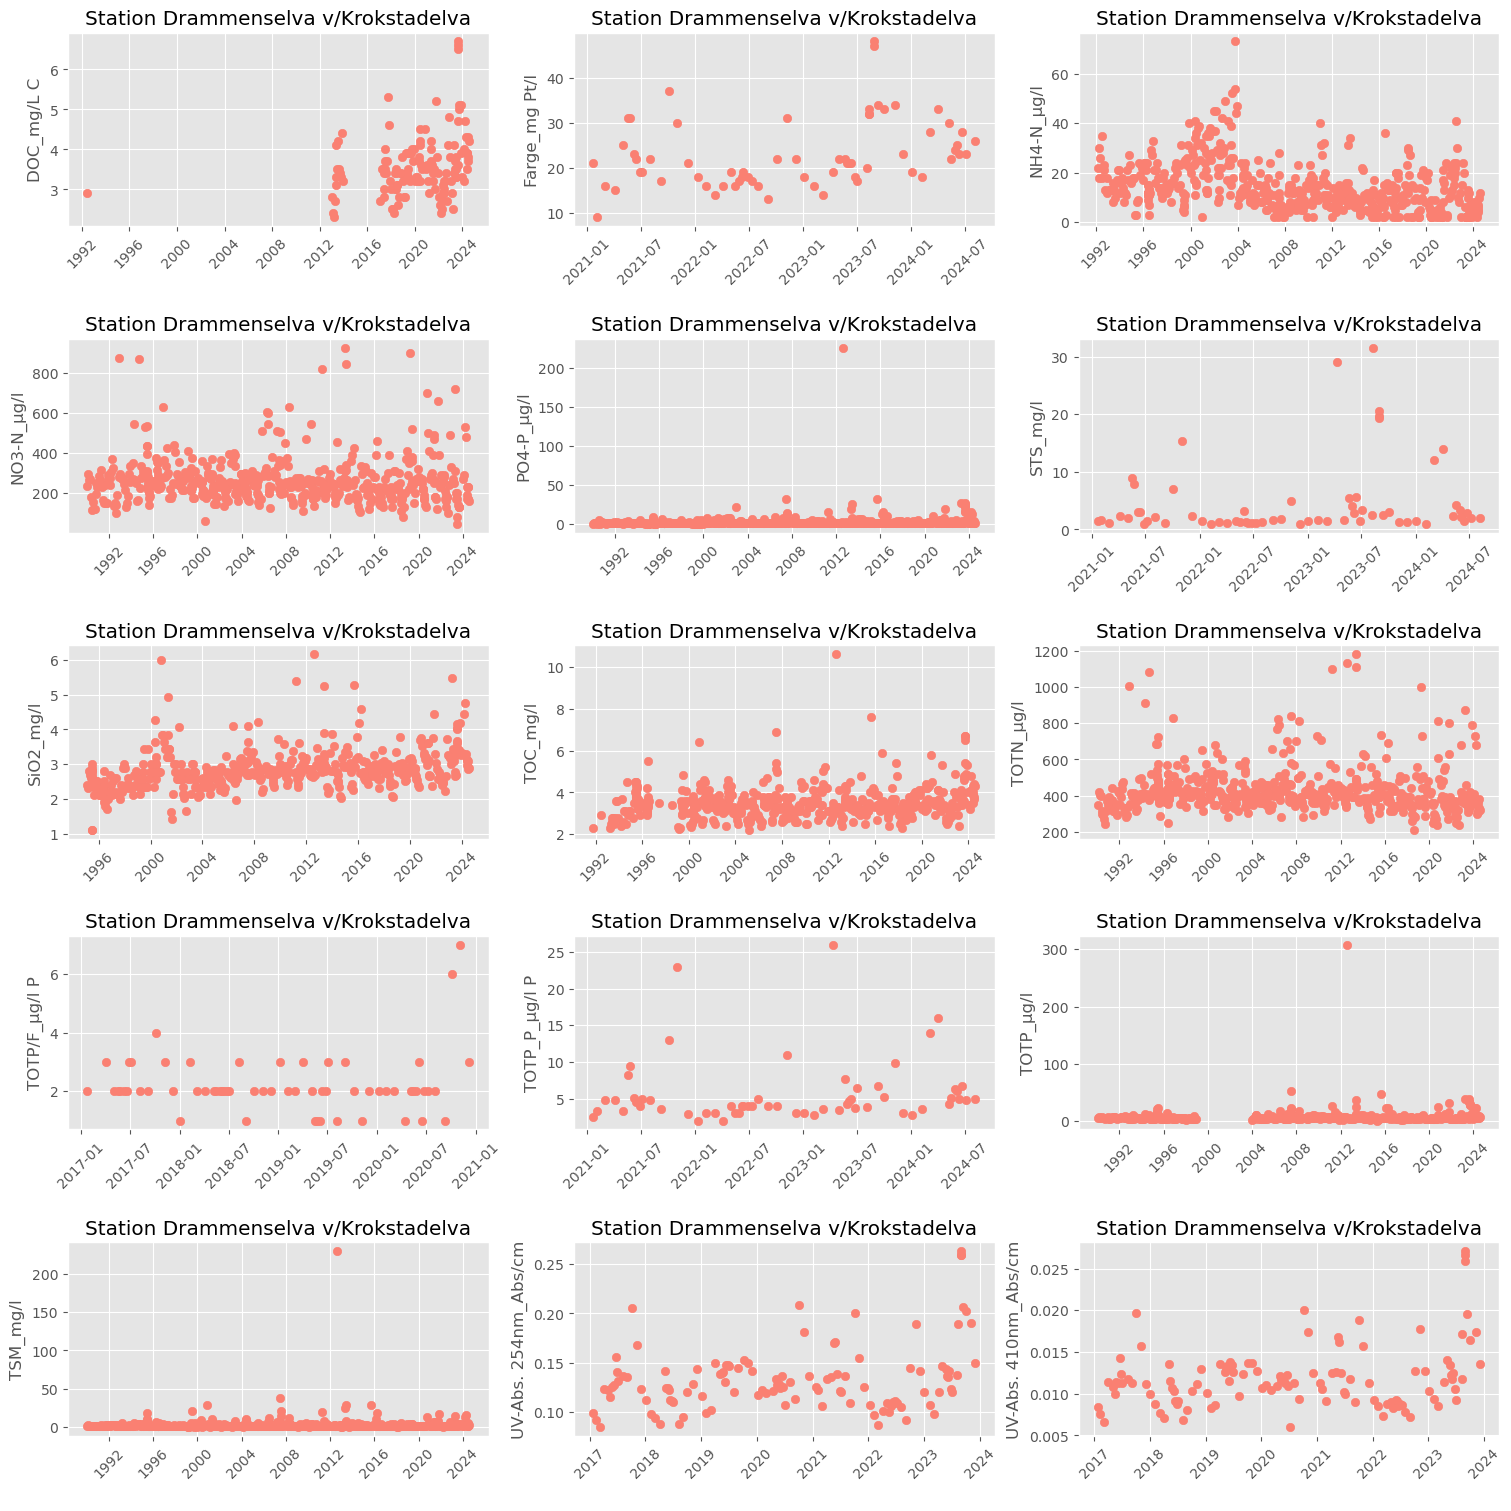

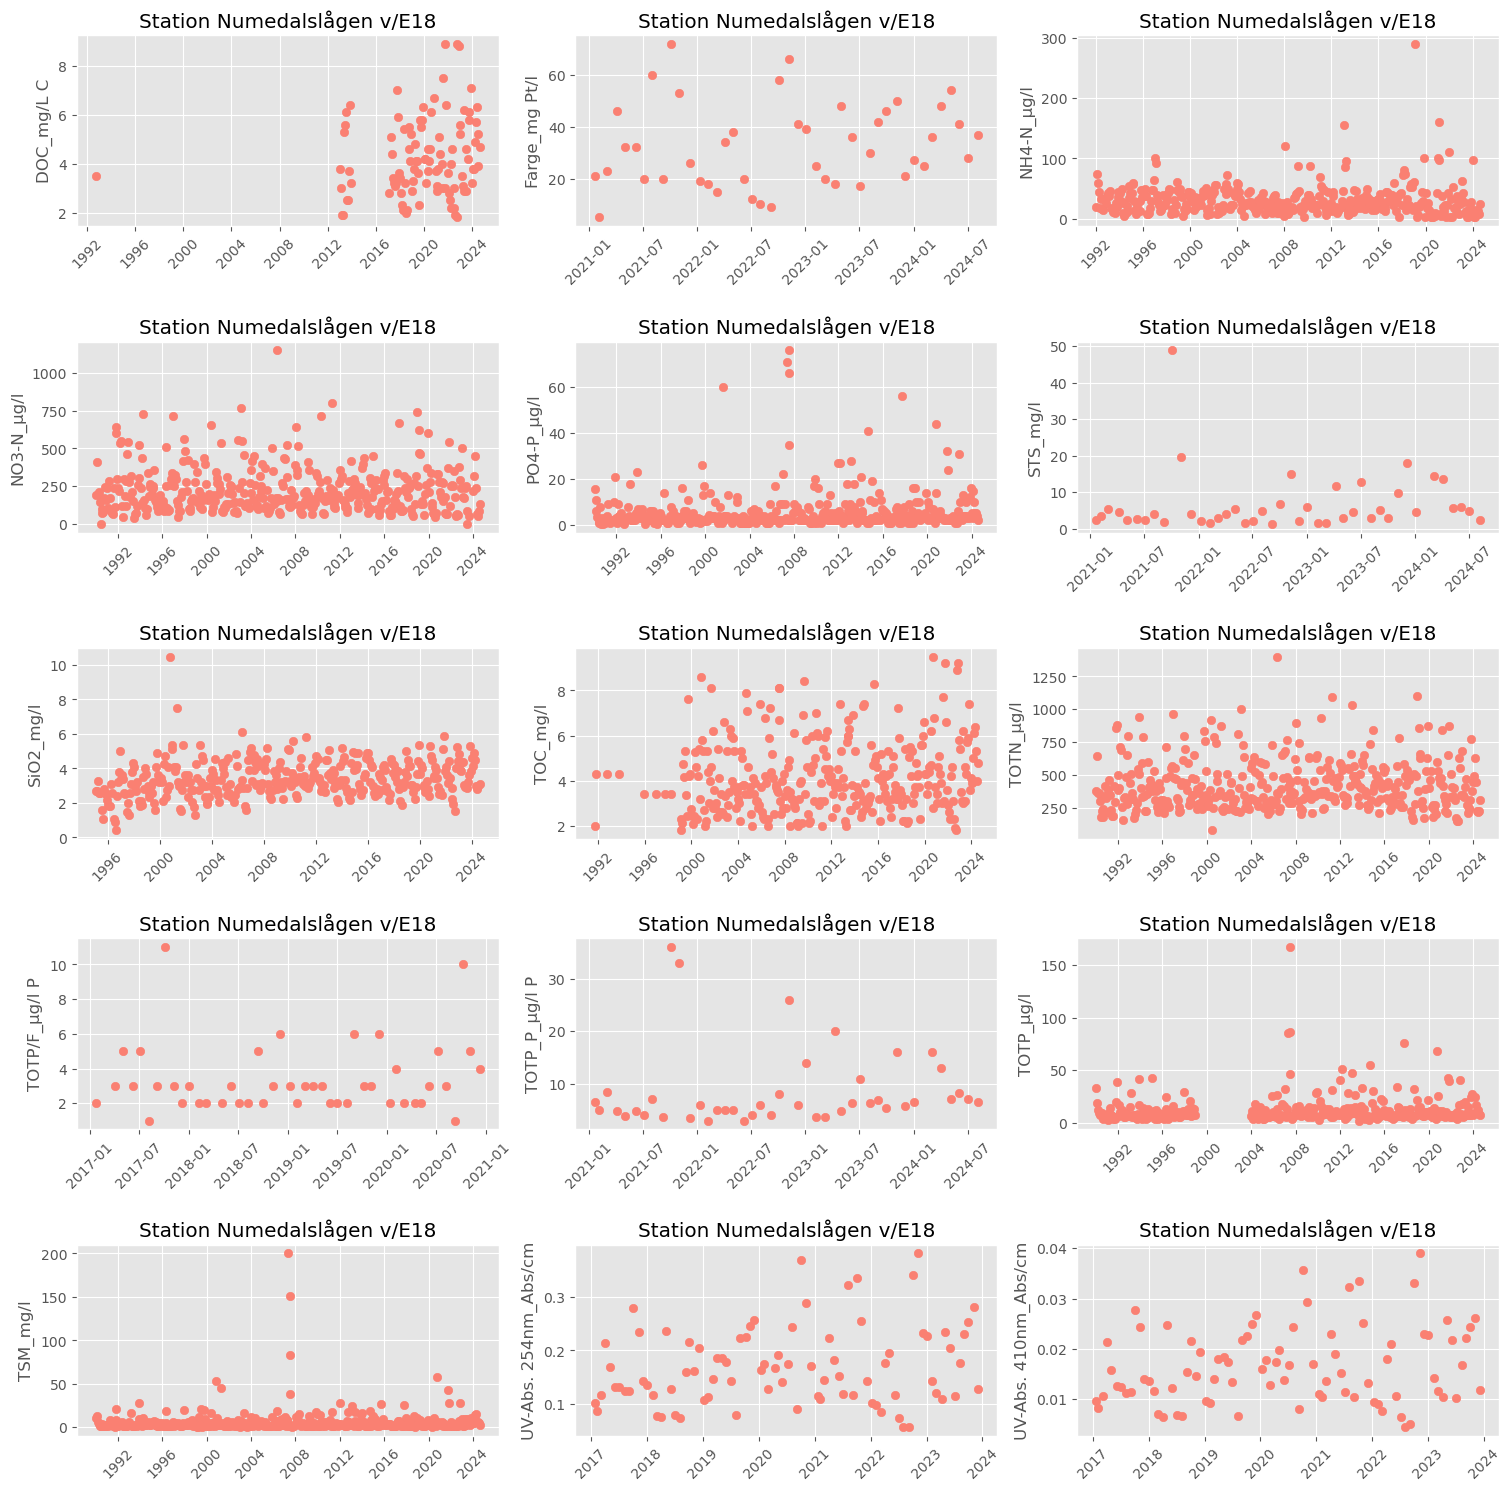

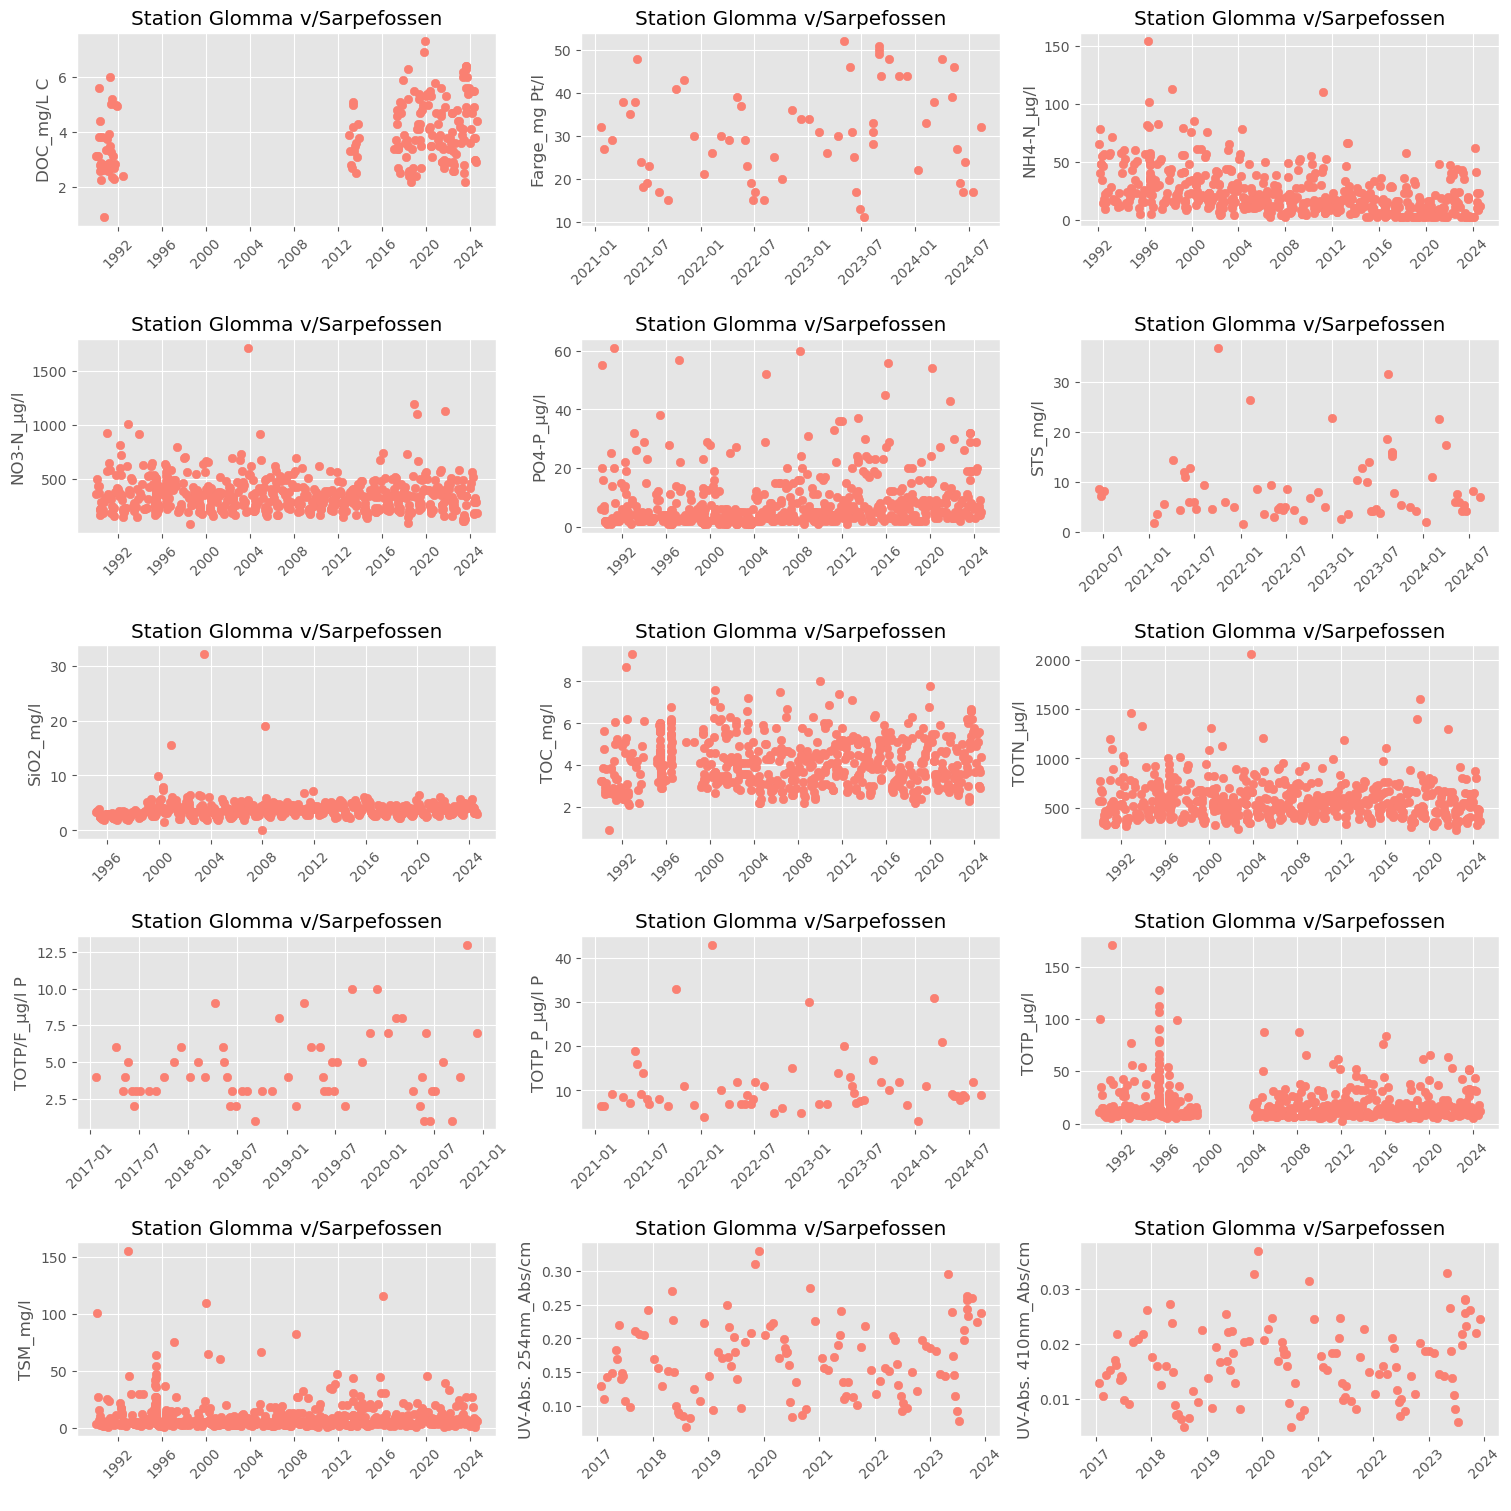

In [3]:
# Station Variable Scatter Plots
stations = wc_df["station_name"].unique()

num_cols = 3

for station in stations:
    station_df = wc_df[wc_df["station_name"] == station]
    
    variables = [col for col in station_df.columns 
                 if col not in ["station_id", "station_code", "station_name", "sample_date"] 
                 and "outlier" not in col]
    
    num_rows = (len(variables) + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)
    
    axes = axes.flatten()
    
    for i, var in enumerate(variables):
        ax = axes[i]
        ax.scatter(station_df["sample_date"], station_df[var], marker='o', color='salmon')
        ax.set_title(f"Station {station}")
        ax.set_xlabel(" ")
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=45)
       
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

In [4]:
wc_df

station_id station_code                 station_name  \
0          40352         DRA1  Drammenselva v/Krokstadelva   
1          40352         DRA1  Drammenselva v/Krokstadelva   
2          40352         DRA1  Drammenselva v/Krokstadelva   
3          40352         DRA1  Drammenselva v/Krokstadelva   
4          40352         DRA1  Drammenselva v/Krokstadelva   
...          ...          ...                          ...   
1627       40356         GLO1         Glomma v/Sarpefossen   
1628       40356         GLO1         Glomma v/Sarpefossen   
1629       40356         GLO1         Glomma v/Sarpefossen   
1630       40356         GLO1         Glomma v/Sarpefossen   
1631       40356         GLO1         Glomma v/Sarpefossen   

             sample_date  DOC_mg/L C outlier_DOC_mg/L C  Farge_mg Pt/l  \
0    1990-01-11 00:00:00         NaN                NaN            NaN   
1    1990-02-12 00:00:00         NaN                NaN            NaN   
2    1990-03-13 00:00:00         NaN                NaN            NaN   
3    1990-04-18 00:00:00         NaN                NaN            NaN   
4    1990-05-21 00:00:00         NaN                NaN            NaN   
...                  ...         ...                ...            ...   
1627 2024-06-03 04:20:00         3.0              False           19.0   
1628 2024-06-12 15:15:00         3.0              False           17.0   
1629 2024-06-20 11:30:00         3.8              False           24.0   
1630 2024-07-15 15:20:00         2.9              False           17.0   
1631 2024-08-13 13:45:00         4.4              False           32.0   

     outlier_Farge_mg Pt/l  NH4-N_µg/l outlier_NH4-N_µg/l  ...  TOTP_P_µg/l P  \
0                      NaN         NaN                NaN  ...            NaN   
1                      NaN         NaN                NaN  ...            NaN   
2                      NaN         NaN                NaN  ...            NaN   
3                      NaN         NaN                NaN  ...            NaN   
4                      NaN         NaN                NaN  ...            NaN   
...                    ...         ...                ...  ...            ...   
1627                 False         8.0              False  ...            7.8   
1628                 False        13.0              False  ...            9.0   
1629                 False         9.0              False  ...            8.5   
1630                 False        23.0              False  ...           12.0   
1631                 False        12.0              False  ...            9.0   

     outlier_TOTP_P_µg/l P  TOTP_µg/l outlier_TOTP_µg/l  TSM_mg/l  \
0                      NaN        6.0             False      0.80   
1                      NaN        7.0             False      2.00   
2                      NaN        6.0             False      1.40   
3                      NaN        5.0             False      1.30   
4                      NaN        6.0             False      1.70   
...                    ...        ...               ...       ...   
1627                 False        7.9             False      4.42   
1628                 False       11.0             False      1.00   
1629                 False       11.0             False      4.63   
1630                 False       18.0             False      6.58   
1631                 False       12.0             False      5.73   

     outlier_TSM_mg/l  UV-Abs. 254nm_Abs/cm outlier_UV-Abs. 254nm_Abs/cm  \
0               False                   NaN                          NaN   
1               False                   NaN                          NaN   
2               False                   NaN                          NaN   
3               False                   NaN                          NaN   
4               False                   NaN                          NaN   
...               ...                   ...                          ...   
1627            False                 

### 3. TSM vs STS

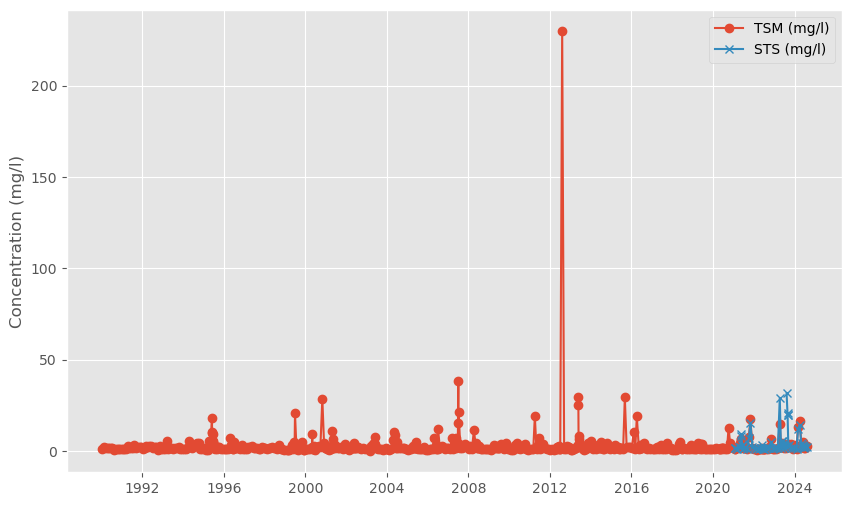

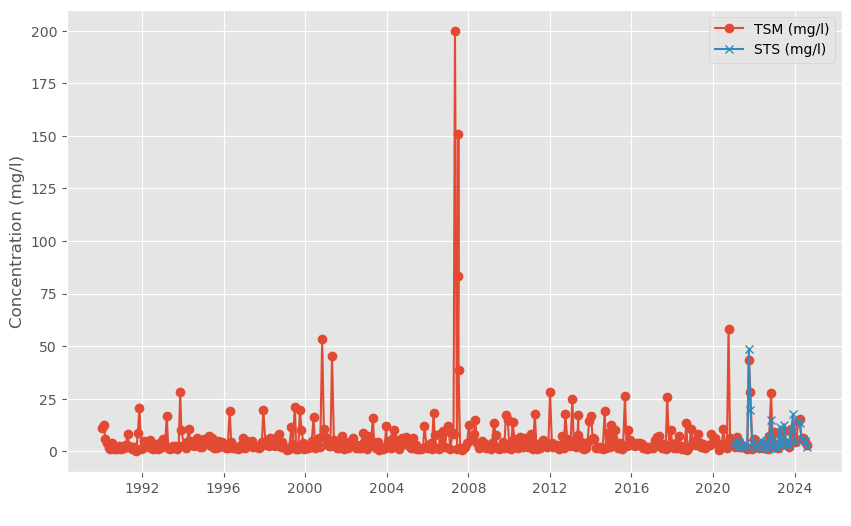

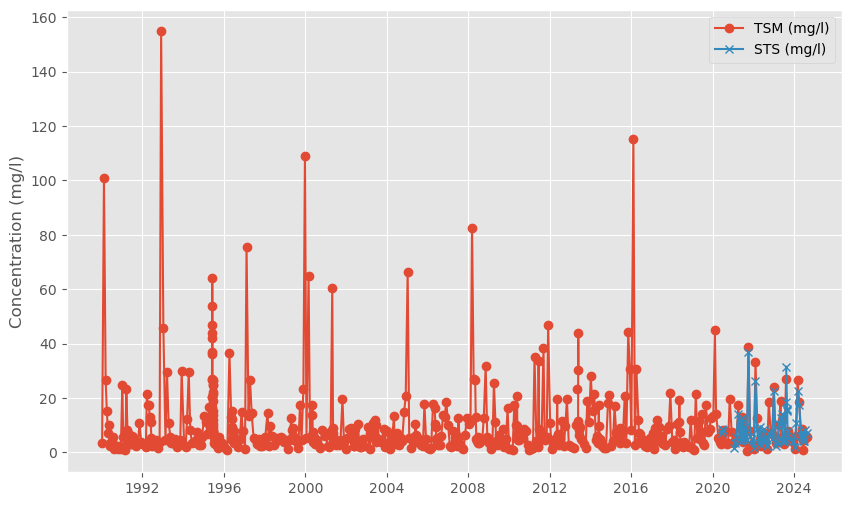

In [5]:
# Plot TSM and STS for each station
stations = wc_df['station_code'].unique()

for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['TSM_mg/l'], label='TSM (mg/l)', marker='o')
    plt.plot(station_df['sample_date'], station_df['STS_mg/l'], label='STS (mg/l)', marker='x') 
    
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Øyvind:** The main difference between the methods is that STS uses "regular" glass fiber filters: GF/C (0.45 µm), and the weighing of the filters takes place on a "regular" analytical weight that weighs grams with 4 (or maybe 5) decimal places. TSM uses nucleopore capillary filters, which have smaller pore size (0.2 µm? - not confirmed with the lab!) than the glass fiber filters. Filters are weighed on a micro-weight, which measures the weight in milligrams with several decimal places. In principle, TSM values should be higher than STS due to smaller filter pore size.

**Leah:** We can just use TSM. We have more data and TSM is moreaccurate than STS.

### 4. DOC vs TOC

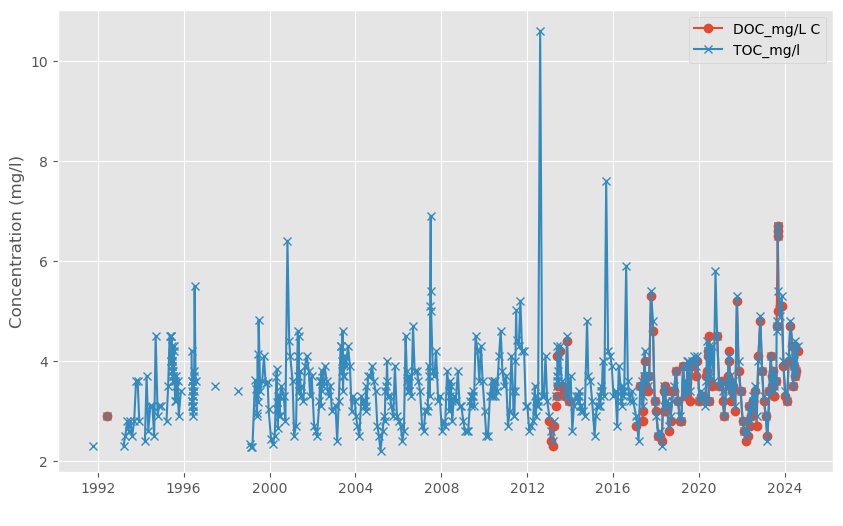

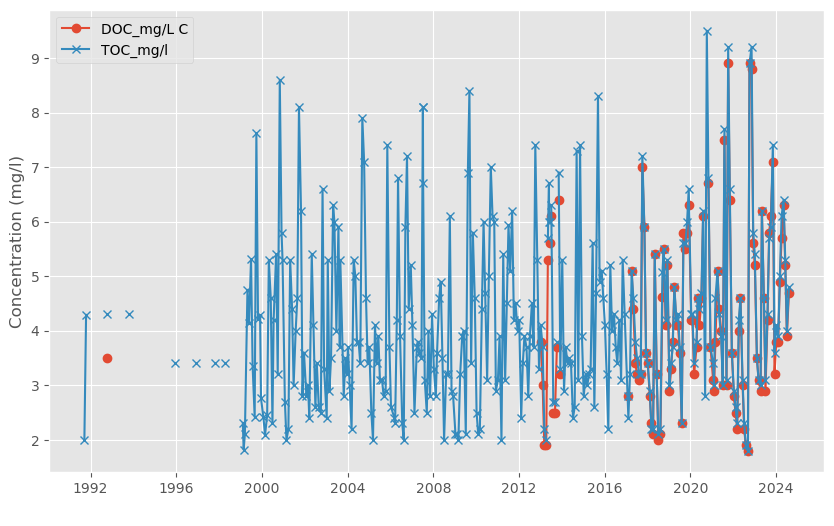

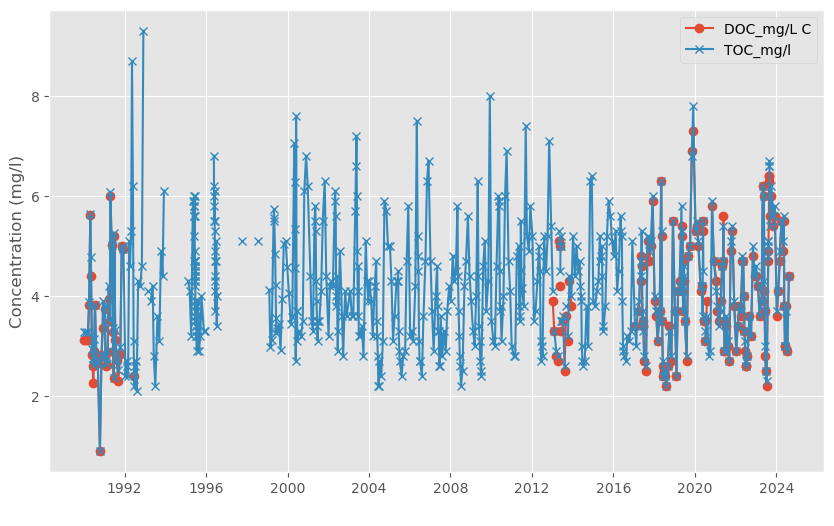

In [6]:
# Plot DOC and TOC for each station
for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['DOC_mg/L C'], label='DOC_mg/L C', marker='o')
    plt.plot(station_df['sample_date'], station_df['TOC_mg/l'], label='TOC_mg/l', marker='x')
    
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Leah:** Looks like DOC basically == TOC in all rivers and that POC is really low. Could you quickly work out the average ratio between DOC and TOC and make a note of it for all 3 rivers? Then lets justify how low that is for assuming that TOC = DOC and just using TOC (given it has a longer and more continuous series).

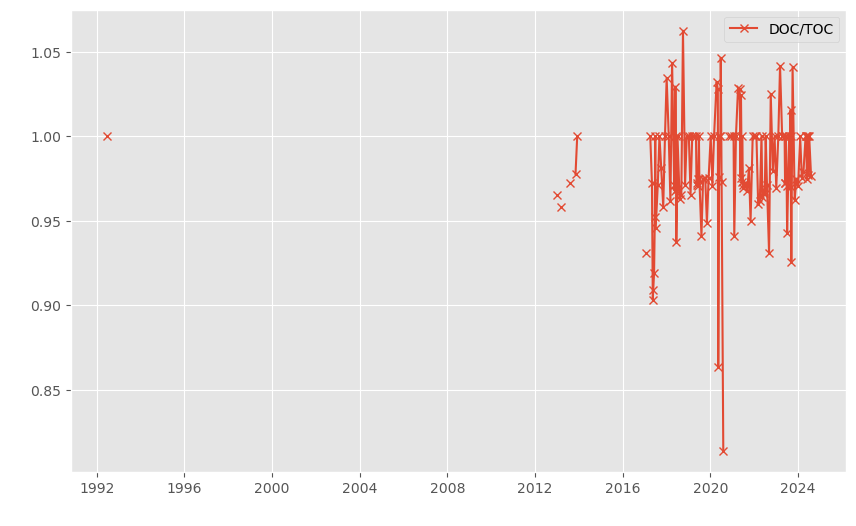

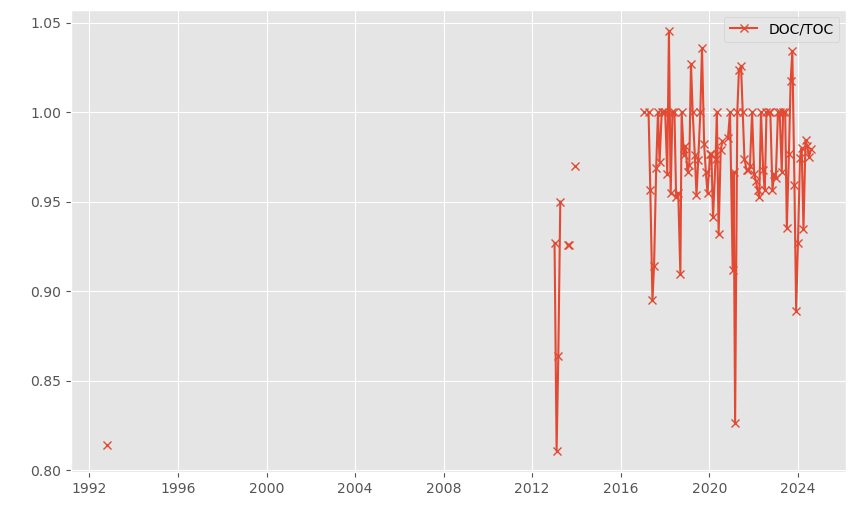

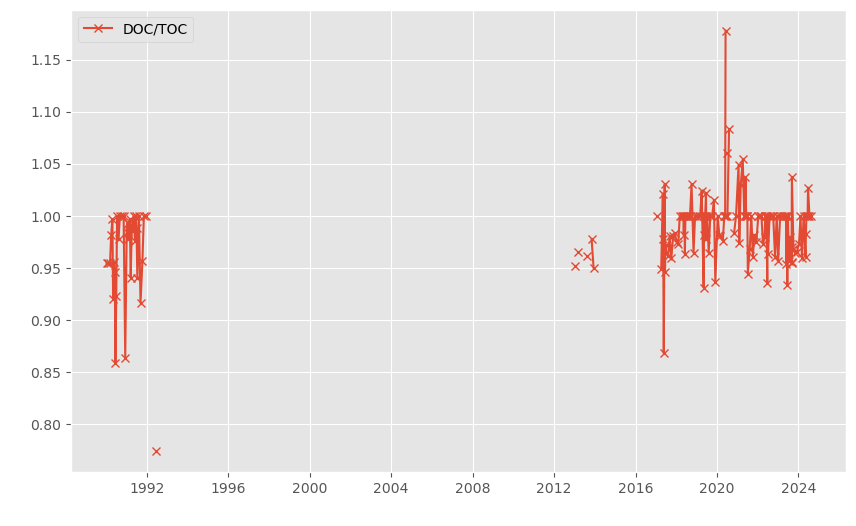

In [7]:
wc_df['DOC/TOC'] = wc_df['DOC_mg/L C'] / wc_df['TOC_mg/l']

for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['DOC/TOC'], label='DOC/TOC', marker='x')
    
    plt.xlabel(' ')
    plt.ylabel(' ')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
ratios = wc_df.groupby('station_code')['DOC/TOC'].mean().reset_index()
ratios

station_code   DOC/TOC
0         DRA1  0.981426
1         GLO1  0.983659
2         NUM1  0.968519

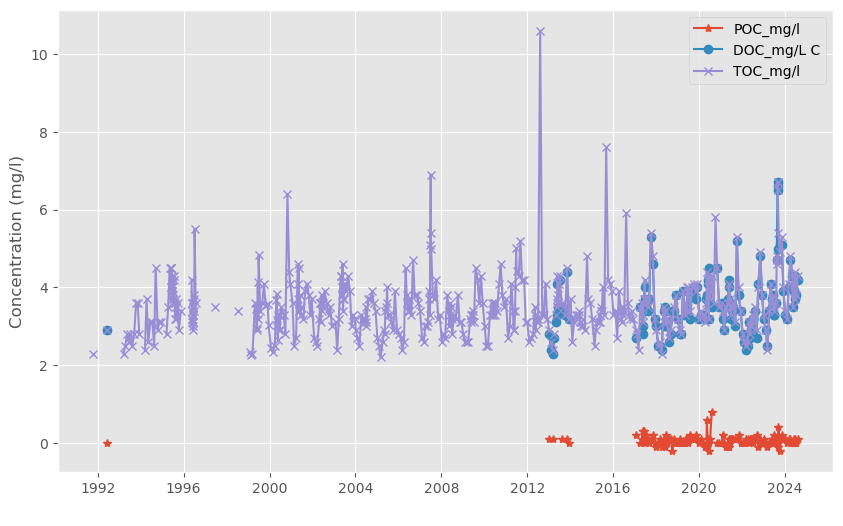

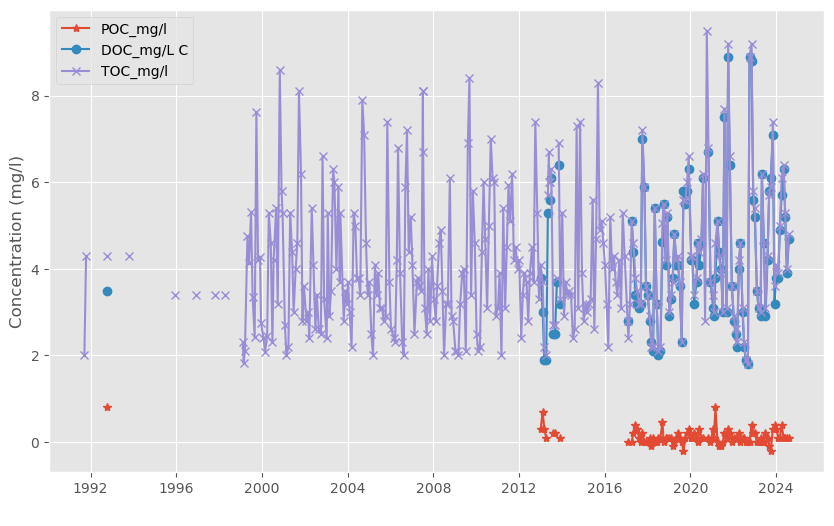

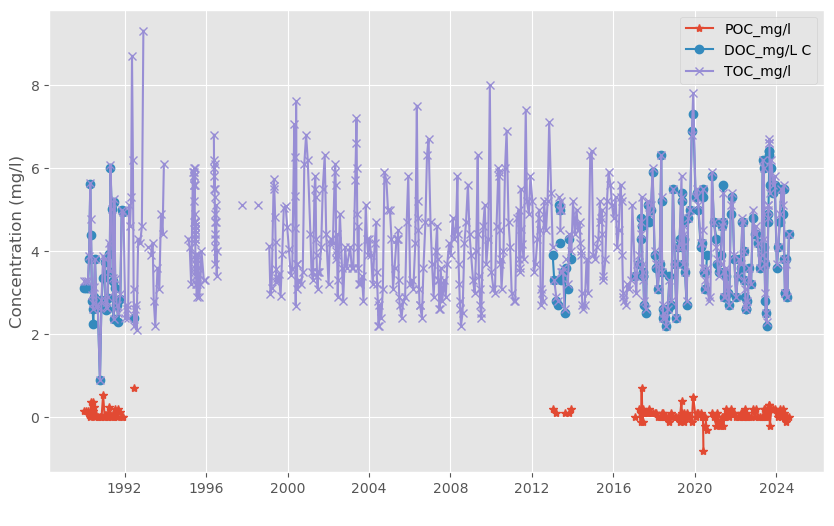

In [9]:
wc_df['POC_mg/l'] = wc_df['TOC_mg/l'] - wc_df['DOC_mg/L C']

for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['POC_mg/l'], label='POC_mg/l', marker='*')
    plt.plot(station_df['sample_date'], station_df['DOC_mg/L C'], label='DOC_mg/L C', marker='o')
    plt.plot(station_df['sample_date'], station_df['TOC_mg/l'], label='TOC_mg/l', marker='x')
    
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Leah:** Incredibly low POC values, as we thought (2-4% of TOC), so that's good justification for just looking at TOC.

### 5. TOTP vs TOTP/F

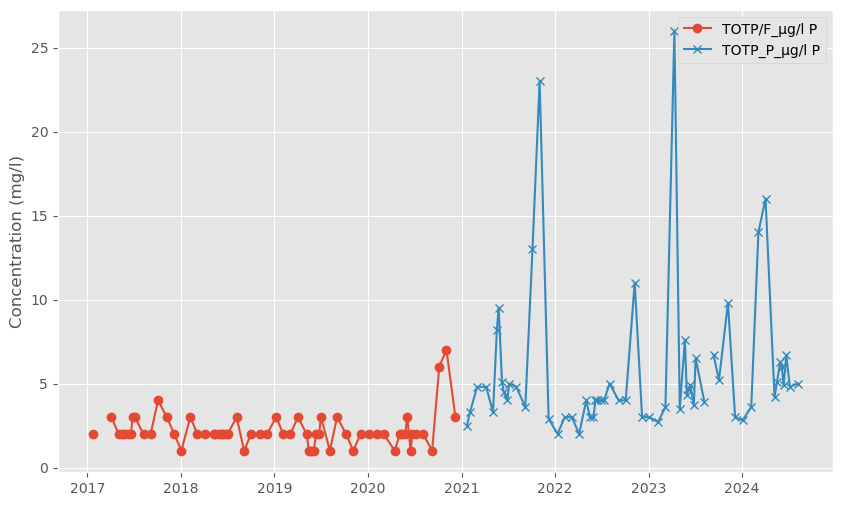

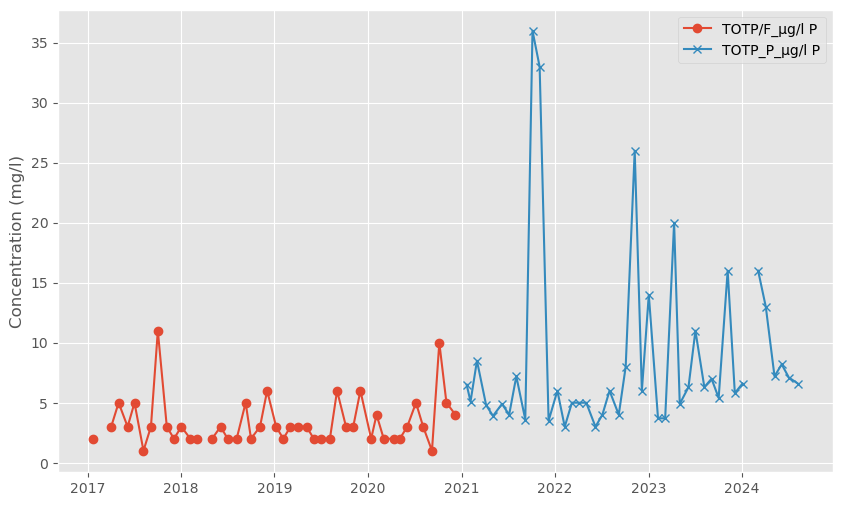

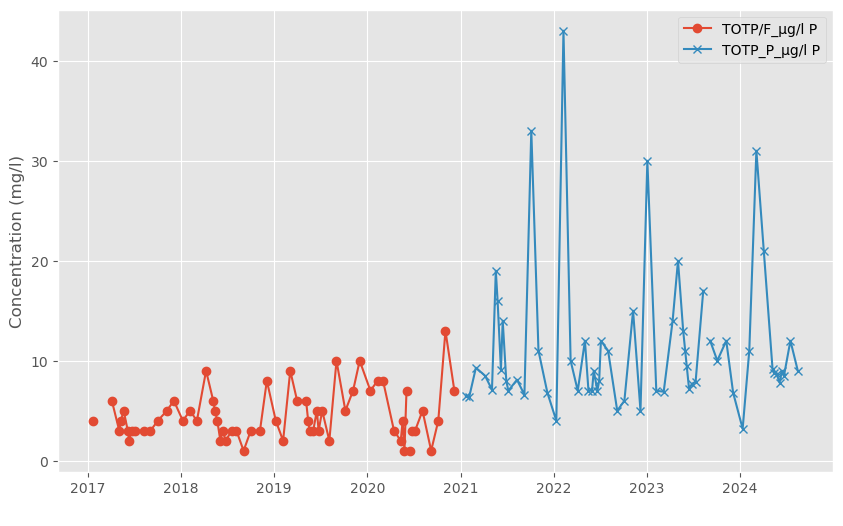

In [10]:
for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['TOTP/F_µg/l P'], label='TOTP/F_µg/l P', marker='o')
    plt.plot(station_df['sample_date'], station_df['TOTP_P_µg/l P'], label='TOTP_P_µg/l P', marker='x')
    
    plt.xlabel(' ')
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

### 6. NH4 vs NO3

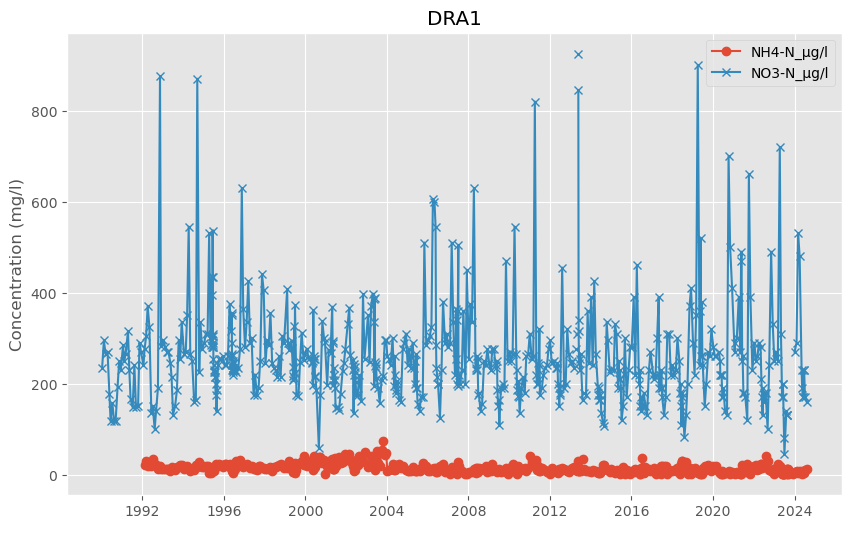

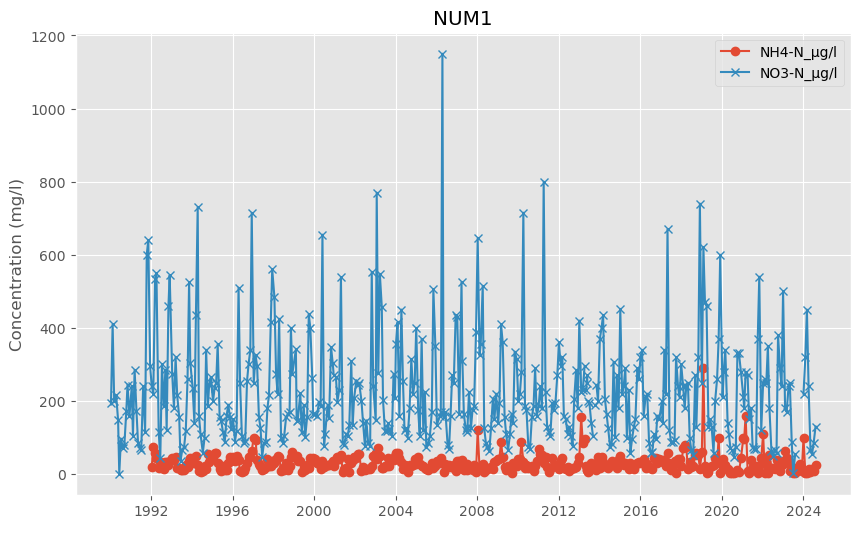

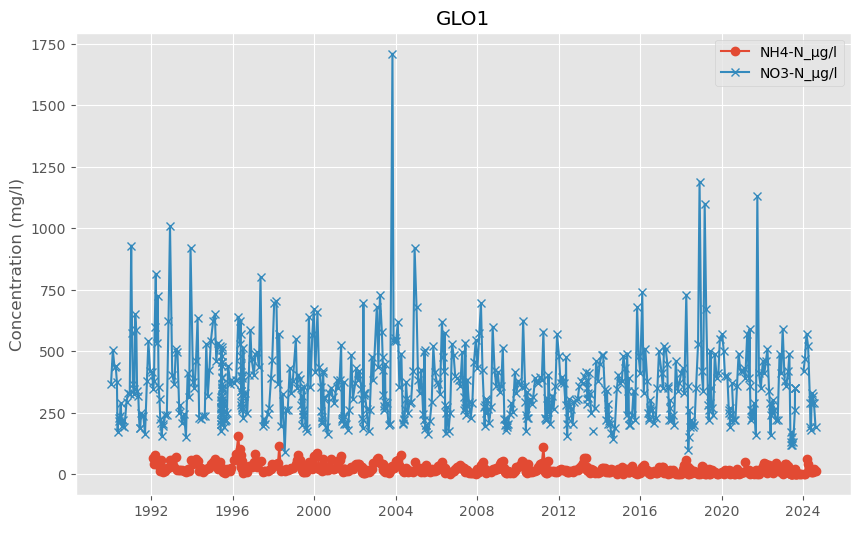

In [11]:
for station in stations:
    station_df = wc_df[wc_df['station_code'] == station]
    
    plt.figure(figsize=(10,6))
    plt.plot(station_df['sample_date'], station_df['NH4-N_µg/l'], label='NH4-N_µg/l', marker='o')
    plt.plot(station_df['sample_date'], station_df['NO3-N_µg/l'], label='NO3-N_µg/l', marker='x')
    
    plt.xlabel(' ')
    plt.title(station)
    plt.ylabel('Concentration (mg/l)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Note:** NO3 values are quite higher compared to NH4, particularly in Dram and Glomma. There are a few exeptions for Num, where NH4 levels are close to NO3, although in general NH4<<NO3, soo we could just summarize those to DIN for simplification.

In [12]:
wc_df['DIN_μg/l'] = wc_df['NH4-N_µg/l'] + wc_df['NO3-N_µg/l']  

# Assign outliers: If NO3-N_µg/l is an outlier, mark DIN_μg/l as an outlier too
if 'outlier_NO3-N_µg/l' in wc_df.columns:
    wc_df['outlier_DIN_μg/l'] = wc_df['outlier_NO3-N_µg/l']  # Copy NO3 outliers

# Drop unnecessary columns 
wc_df = wc_df.drop(columns=['NH4-N_µg/l', 'NO3-N_µg/l', 'STS_mg/l', 'DOC/TOC', 'POC_mg/l', 'DOC_mg/L C', 
                            'outlier_NH4-N_µg/l', 'outlier_NO3-N_µg/l', 'outlier_STS_mg/l', 'outlier_DOC_mg/L C'])
wc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1632 entries, 0 to 1631
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   station_id                    1632 non-null   int64         
 1   station_code                  1632 non-null   object        
 2   station_name                  1632 non-null   object        
 3   sample_date                   1632 non-null   datetime64[ns]
 4   Farge_mg Pt/l                 174 non-null    float64       
 5   outlier_Farge_mg Pt/l         174 non-null    object        
 6   PO4-P_µg/l                    1558 non-null   float64       
 7   outlier_PO4-P_µg/l            1558 non-null   object        
 8   SiO2_mg/l                     1353 non-null   float64       
 9   outlier_SiO2_mg/l             1353 non-null   object        
 10  TOC_mg/l                      1385 non-null   float64       
 11  outlier_TOC_mg/l              

In [13]:
wc_df.keys()

Index(['station_id', 'station_code', 'station_name', 'sample_date',
       'Farge_mg Pt/l', 'outlier_Farge_mg Pt/l', 'PO4-P_µg/l',
       'outlier_PO4-P_µg/l', 'SiO2_mg/l', 'outlier_SiO2_mg/l', 'TOC_mg/l',
       'outlier_TOC_mg/l', 'TOTN_µg/l', 'outlier_TOTN_µg/l', 'TOTP/F_µg/l P',
       'outlier_TOTP/F_µg/l P', 'TOTP_P_µg/l P', 'outlier_TOTP_P_µg/l P',
       'TOTP_µg/l', 'outlier_TOTP_µg/l', 'TSM_mg/l', 'outlier_TSM_mg/l',
       'UV-Abs. 254nm_Abs/cm', 'outlier_UV-Abs. 254nm_Abs/cm',
       'UV-Abs. 410nm_Abs/cm', 'outlier_UV-Abs. 410nm_Abs/cm', 'DIN_μg/l',
       'outlier_DIN_μg/l'],
      dtype='object')

### 7. Glomma Farge vs sensor 

**Leah:** The main reason to  look at UV-Abs is to quality control the CDOM data. Hopefully there is an extremely good correlation with UV-Abs! If not, then one or the other is dodgy... So it's fine if we only have data after 2017. We're not interested in fluxes of UV-Abs to the fjord.

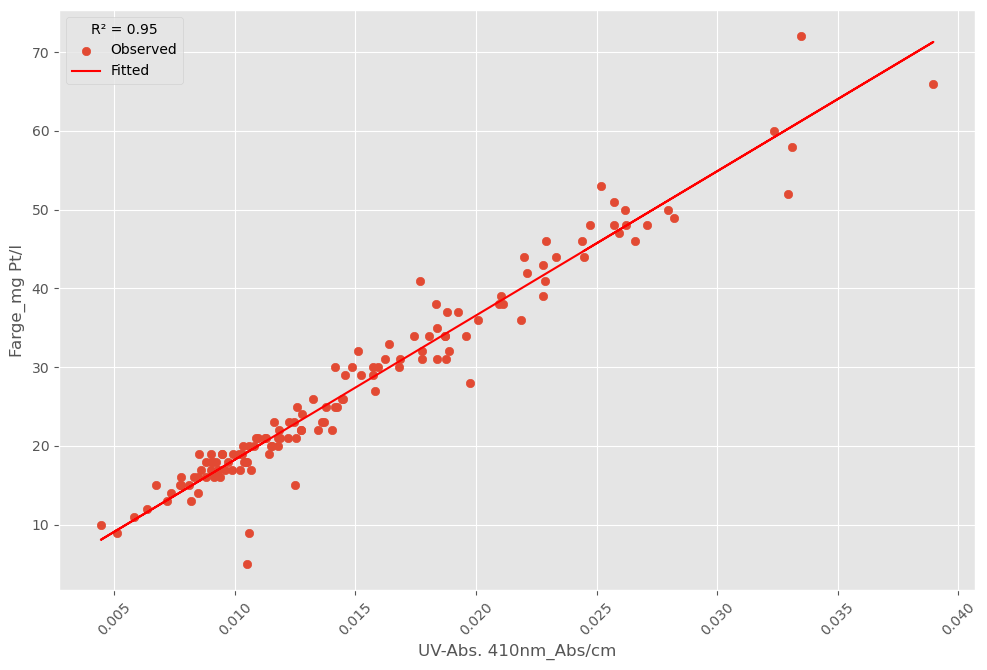

{('Farge_mg Pt/l', 'UV-Abs. 410nm_Abs/cm'): [0.9477900121931774, 1831.2807314777942, -0.05421336099591012]}


In [14]:
# Variables of interest
wc_var_1 = 'Farge_mg Pt/l'
wc_var_2 = 'UV-Abs. 410nm_Abs/cm'

# Initialize dictionary to store model coefficients and R-squared values
model_r2_coeffs = {}

fig, ax = plt.subplots(figsize=(10, 7))
df_reg = wc_df[[wc_var_1, wc_var_2]].dropna()
    
if not wc_df.empty:
    X = sm.add_constant(df_reg[wc_var_2])  # independent variable
    y = df_reg[wc_var_1]  # dependent variable
        
    model = sm.OLS(y, X)
    results = model.fit()
        
    m, c = results.params[wc_var_2], results.params['const']
    model_r2_coeffs[(wc_var_1, wc_var_2)] = [results.rsquared, m, c]
        
    ax.scatter(df_reg[wc_var_2], df_reg[wc_var_1], label='Observed')
    ax.plot(df_reg[wc_var_2], results.fittedvalues, color='red', label='Fitted')
    ax.set_xlabel(wc_var_2)
    ax.set_ylabel(wc_var_1)
    r2 = results.rsquared
    ax.legend(title=f'R² = {r2:.2f}')
    ax.tick_params(axis='x', rotation=45) 
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

print(model_r2_coeffs)

In [15]:
df_glo = wc_df[wc_df['station_code'].str.contains('GLO')]
df_glo.head()

station_id station_code          station_name sample_date  \
1014       40356         GLO1  Glomma v/Sarpefossen  1990-01-10   
1015       40356         GLO1  Glomma v/Sarpefossen  1990-02-12   
1016       40356         GLO1  Glomma v/Sarpefossen  1990-03-14   
1017       40356         GLO1  Glomma v/Sarpefossen  1990-04-04   
1018       40356         GLO1  Glomma v/Sarpefossen  1990-04-26   

      Farge_mg Pt/l outlier_Farge_mg Pt/l  PO4-P_µg/l outlier_PO4-P_µg/l  \
1014            NaN                   NaN         6.0              False   
1015            NaN                   NaN        55.0              False   
1016            NaN                   NaN        20.0              False   
1017            NaN                   NaN        16.0              False   
1018            NaN                   NaN         5.5              False   

      SiO2_mg/l outlier_SiO2_mg/l  ...  TOTP_µg/l outlier_TOTP_µg/l  TSM_mg/l  \
1014        NaN               NaN  ...       11.0             False       3.5   
1015        NaN               NaN  ...      100.0             False     100.8   
1016        NaN               NaN  ...       35.0             False      26.8   
1017        NaN               NaN  ...       27.0             False      15.3   
1018        NaN               NaN  ...       15.0             False       7.1   

     outlier_TSM_mg/l  UV-Abs. 254nm_Abs/cm outlier_UV-Abs. 254nm_Abs/cm  \
1014            False                   NaN                          NaN   
1015             True                   NaN                          NaN   
1016            False                   NaN                          NaN   
1017            False                   NaN                          NaN   
1018            False                   NaN                          NaN   

      UV-Abs. 410nm_Abs/cm outlier_UV-Abs. 410nm_Abs/cm  DIN_μg/l  \
1014                   NaN                          NaN       NaN   
1015                   NaN                          NaN       NaN   
1016                   NaN                          NaN       NaN   
1017                   NaN                          NaN       NaN   
1018                   NaN                          NaN       NaN   

     outlier_DIN_μg/l  
1014            False  
1015            False  
1016            False  
1017            False  
1018            False  

[5 rows x 28 columns]

In [16]:
sensor_df = pd.read_csv("../../data/river/sensors/daily_glomma_sensor_data_2024-08-28_cleaned_manualy.csv")
# sensor_df = sensor_df.drop('Unnamed: 0', axis=1)
sensor_df['Date'] = pd.to_datetime(sensor_df['Date'])
sensor_df.set_index('Date', inplace=True)
sensor_df.head()

CDOMdigitalFinal (µg/L)  PhValue_Avg (-)  Temp_water_Avg (degC)  \
Date                                                                          
2023-02-02                   76.000              NaN                 0.0900   
2023-02-03                   75.430           7.5330                 0.0595   
2023-02-04                   74.765           7.3875                 0.0300   
2023-02-05                   74.645           7.2770                 0.0635   
2023-02-06                   73.385           7.2950                 0.1325   

            CondValue_Avg (µS/cm)  Turbidity_Avg (NTU)  Salinity_Avg (-)  
Date                                                                      
2023-02-02                 35.350               8.1700             0.019  
2023-02-03                 34.580               8.1200             0.019  
2023-02-04                 33.615               8.8900             0.018  
2023-02-05                 32.585               7.8885             0.017  
2023-02-06                 32.685               6.1120             0.018

In [17]:
df_glo['sample_date'] = pd.to_datetime(df_glo['sample_date'])
df_glo.set_index('sample_date', inplace=True)
df_glo.index = df_glo.index.normalize()
df_glo.head()

/tmp/ipykernel_2506/313209916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glo['sample_date'] = pd.to_datetime(df_glo['sample_date'])


station_id station_code          station_name  Farge_mg Pt/l  \
sample_date                                                                 
1990-01-10        40356         GLO1  Glomma v/Sarpefossen            NaN   
1990-02-12        40356         GLO1  Glomma v/Sarpefossen            NaN   
1990-03-14        40356         GLO1  Glomma v/Sarpefossen            NaN   
1990-04-04        40356         GLO1  Glomma v/Sarpefossen            NaN   
1990-04-26        40356         GLO1  Glomma v/Sarpefossen            NaN   

            outlier_Farge_mg Pt/l  PO4-P_µg/l outlier_PO4-P_µg/l  SiO2_mg/l  \
sample_date                                                                   
1990-01-10                    NaN         6.0              False        NaN   
1990-02-12                    NaN        55.0              False        NaN   
1990-03-14                    NaN        20.0              False        NaN   
1990-04-04                    NaN        16.0              False        NaN   
1990-04-26                    NaN         5.5              False        NaN   

            outlier_SiO2_mg/l  TOC_mg/l  ... TOTP_µg/l  outlier_TOTP_µg/l  \
sample_date                              ...                                
1990-01-10                NaN      3.27  ...      11.0              False   
1990-02-12                NaN      3.27  ...     100.0              False   
1990-03-14                NaN      3.27  ...      35.0              False   
1990-04-04                NaN      3.88  ...      27.0              False   
1990-04-26                NaN      5.64  ...      15.0              False   

            TSM_mg/l  outlier_TSM_mg/l UV-Abs. 254nm_Abs/cm  \
sample_date                                                   
1990-01-10       3.5             False                  NaN   
1990-02-12     100.8              True                  NaN   
1990-03-14      26.8             False                  NaN   
1990-04-04      15.3             False                  NaN   
1990-04-26       7.1             False                  NaN   

             outlier_UV-Abs. 254nm_Abs/cm UV-Abs. 410nm_Abs/cm  \
sample_date                                                      
1990-01-10                            NaN                  NaN   
1990-02-12                            NaN                  NaN   
1990-03-14                            NaN                  NaN   
1990-04-04                            NaN                  NaN   
1990-04-26                            NaN                  NaN   

             outlier_UV-Abs. 410nm_Abs/cm DIN_μg/l  outlier_DIN_μg/l  
sample_date                                                           
1990-01-10                            NaN      NaN             False  
1990-02-12                            NaN      NaN             False  
1990-03-14                            NaN      NaN             False  
1990-04-04                            NaN      NaN             False  
1990-04-26                            NaN      NaN             False  

[5 rows x 27 columns]

In [18]:
merged_df = pd.merge(sensor_df, df_glo, left_index=True, right_index=True, how='inner')
merged_df

CDOMdigitalFinal (µg/L)  PhValue_Avg (-)  Temp_water_Avg (degC)  \
2023-02-06                   73.385           7.2950                 0.1325   
2023-03-07                   60.425           7.3010                 0.3850   
2023-04-11                   57.580           7.0975                 3.1395   
2023-05-02                   87.100           6.7215                 4.3035   
2023-05-22                   81.650           6.0940                 8.0650   
2023-05-30                   60.410           6.2595                 9.1550   
2023-06-05                   54.160           6.3840                10.3550   
2023-06-14                   37.475           6.4595                14.8400   
2023-06-26                   28.675           6.4945                17.7650   
2023-07-10                   25.960           6.5365                17.6650   
2023-08-09                   54.150           6.2560                16.3100   
2023-08-11                   43.855           6.2510                16.1050   
2023-08-11                   43.855           6.2510                16.1050   
2023-08-11                   43.855           6.2510                16.1050   
2023-08-11                   43.855           6.2510                16.1050   
2023-08-29                   63.830           6.1325                15.4150   
2023-08-29                   63.830           6.1325                15.4150   
2023-08-29                   63.830           6.1325                15.4150   
2023-09-05                   71.015           6.1615                15.2850   
2023-10-03                   83.100           6.1885                11.0350   
2023-11-07                   84.400           6.4005                 5.0180   
2023-12-04                   90.950           6.4550                -0.0045   
2024-01-10                   68.275           6.3620                -0.0125   
2024-02-05                   66.985           6.3400                 0.0025   
2024-03-04                   57.380           6.3210                 0.3690   
2024-04-02                   69.450           6.2485                 2.2540   
2024-05-06                   71.005           6.1270                 8.4300   
2024-05-13                   79.840           6.0110                 8.4350   
2024-05-22                   53.195           7.1590                11.8150   
2024-06-03                   38.420              NaN                13.6150   
2024-06-12                   37.045              NaN                13.0550   
2024-06-20                   47.835           7.4425                13.1900   
2024-07-15                   35.460           7.0725                15.7200   
2024-08-13                   55.120           6.5775                18.0950   

            CondValue_Avg (µS/cm)  Turbidity_Avg (NTU)  Salinity_Avg (-)  \
2023-02-06                 32.685               6.1120            0.0180   
2023-03-07                 40.065               9.0450            0.0210   
2023-04-11                 49.215              16.9250            0.0260   
2023-05-02                 41.890              22.2600            0.0220   
2023-05-22                 29.050              12.1200            0.0160   
2023-05-30                 30.755               8.9650            0.0160   
2023-06-05                 34.245               5.0805            0.0180   
2023-06-14                 38.800               5.0670            0.0210   
2023-06-26                 40.335               5.9105            0.0220   
2023-07-10                 37.625               4.9975            0.0200   
2023-08-09                 31.790              16.6100            0.0170   
2023-08-11                 37.070              49.7150            0.0200   
2023-08-11                 37.070              49.7150            0.0200   
2023-08-11                 37.070              49.7150            0.0200   
2023-08-11                 37.070              49.7150            0.0200   
2023-08-29                 30.

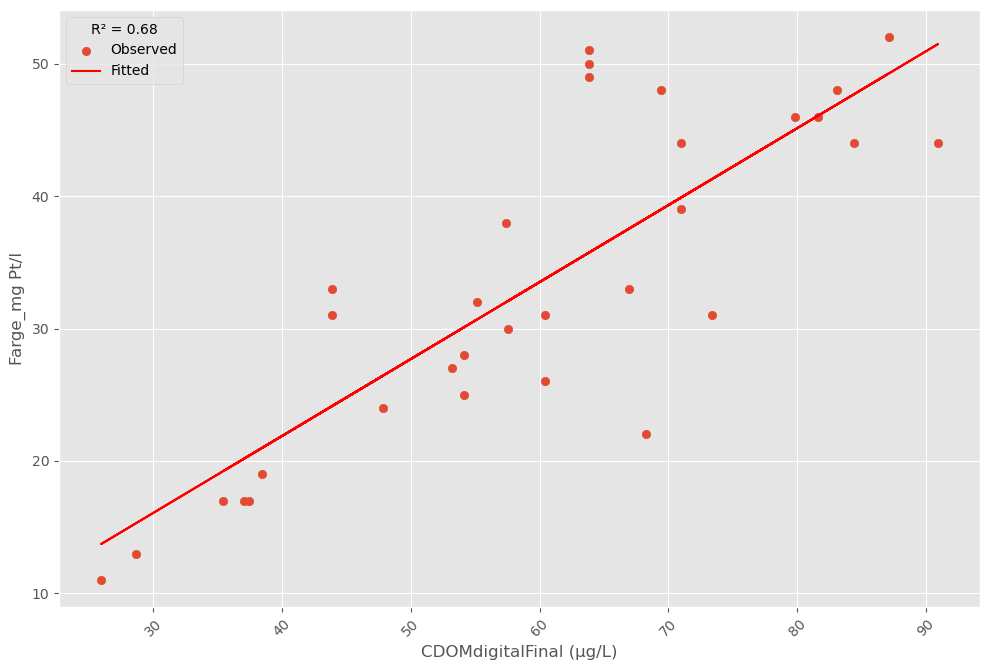

{('Farge_mg Pt/l', 'CDOMdigitalFinal (µg/L)'): [0.6785617004656879, 0.5810620961937265, -1.3631977089334075]}


In [19]:
# Variables of interest
wc_var = 'Farge_mg Pt/l' #'UV-Abs. 410nm_Abs/cm'
sensor_var = 'CDOMdigitalFinal (µg/L)'

# Initialize dictionary to store model coefficients and R-squared values
model_r2_coeffs = {}


fig, ax = plt.subplots(figsize=(10, 7))
    
# Filter the DataFrame for the variables of interest and drop missing values
df_reg = merged_df[[wc_var, sensor_var]].dropna()
    
if not merged_df.empty:
    X = sm.add_constant(df_reg[sensor_var])  # independent variable
    y = df_reg[wc_var]  # dependent variable
        
    model = sm.OLS(y, X)
    results = model.fit()
        
    m, c = results.params[sensor_var], results.params['const']
    model_r2_coeffs[(wc_var, sensor_var)] = [results.rsquared, m, c]
        
    ax.scatter(df_reg[sensor_var], df_reg[wc_var], label='Observed')
    ax.plot(df_reg[sensor_var], results.fittedvalues, color='red', label='Fitted')
    ax.set_xlabel(sensor_var)
    ax.set_ylabel(wc_var)
    r2 = results.rsquared
    ax.legend(title=f'R² = {r2:.2f}')
    ax.tick_params(axis='x', rotation=45) 
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

print(model_r2_coeffs)

**Leah:** The UV-Abs vs CDOM regression is ok, but actually not as nice as I would have hoped. I wonder whether that's a problem with the CDOM or the UVAbs, or whether it's just that CDOM is measuring a different part of the spectrum. Quick question: does farge vs CDOM look any better? How about farge vs UV-Abs? Just trying to figure out which of these variables are untrustworthy...

### 8. Parameters of interest 

After looking into the data we ended up with the following key chemical species: TSM, TOC, DIN, Farge, PO4-P, SiO2, TOTN, TOTP - filtered, TOTP - unfiltered. UV-Abs. 410nm_Abs/cm is included only for comparisons with the sensor data in Glomma.

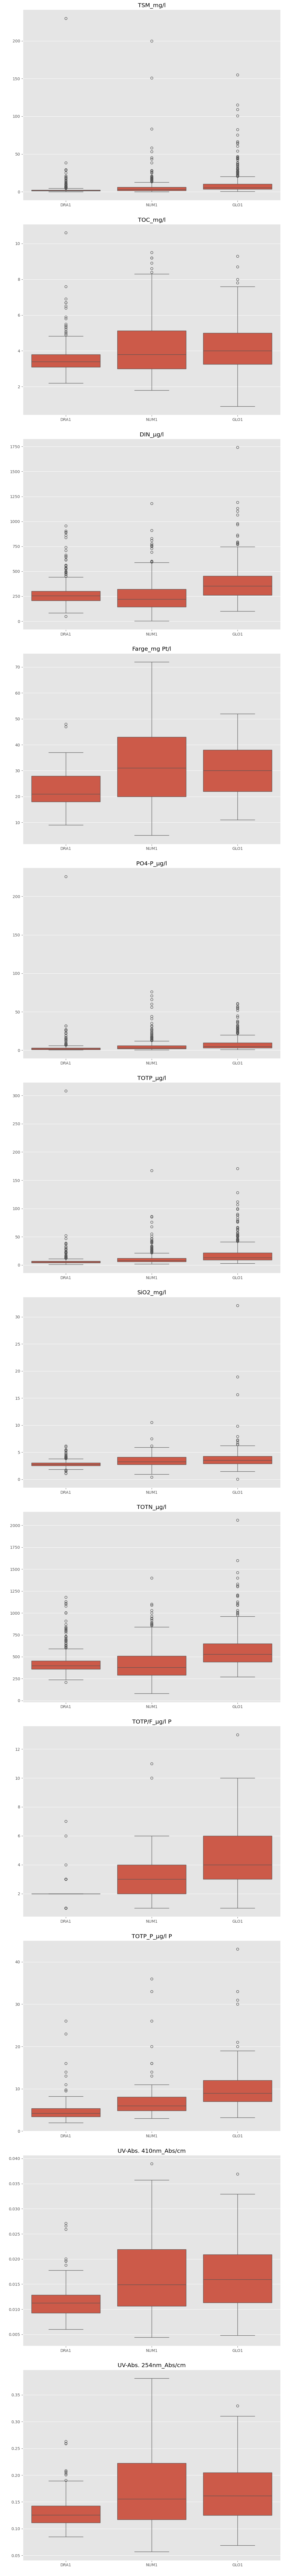

In [20]:
pars = ['TSM_mg/l', 'TOC_mg/l', 'DIN_μg/l', 'Farge_mg Pt/l', 'PO4-P_µg/l', 'TOTP_µg/l',
        'SiO2_mg/l', 'TOTN_µg/l', 'TOTP/F_µg/l P', 'TOTP_P_µg/l P', 'UV-Abs. 410nm_Abs/cm', 'UV-Abs. 254nm_Abs/cm']

fig, axes = plt.subplots(nrows=len(pars), ncols=1, figsize=(10, len(variables) * 6))
for i, par in enumerate(pars):
    sns.boxplot(x='station_code', y=par, data=wc_df, ax=axes[i])
    axes[i].set_title(f'{par}')
    axes[i].set_xlabel(' ')
    axes[i].set_ylabel(' ')

plt.tight_layout()
plt.show()

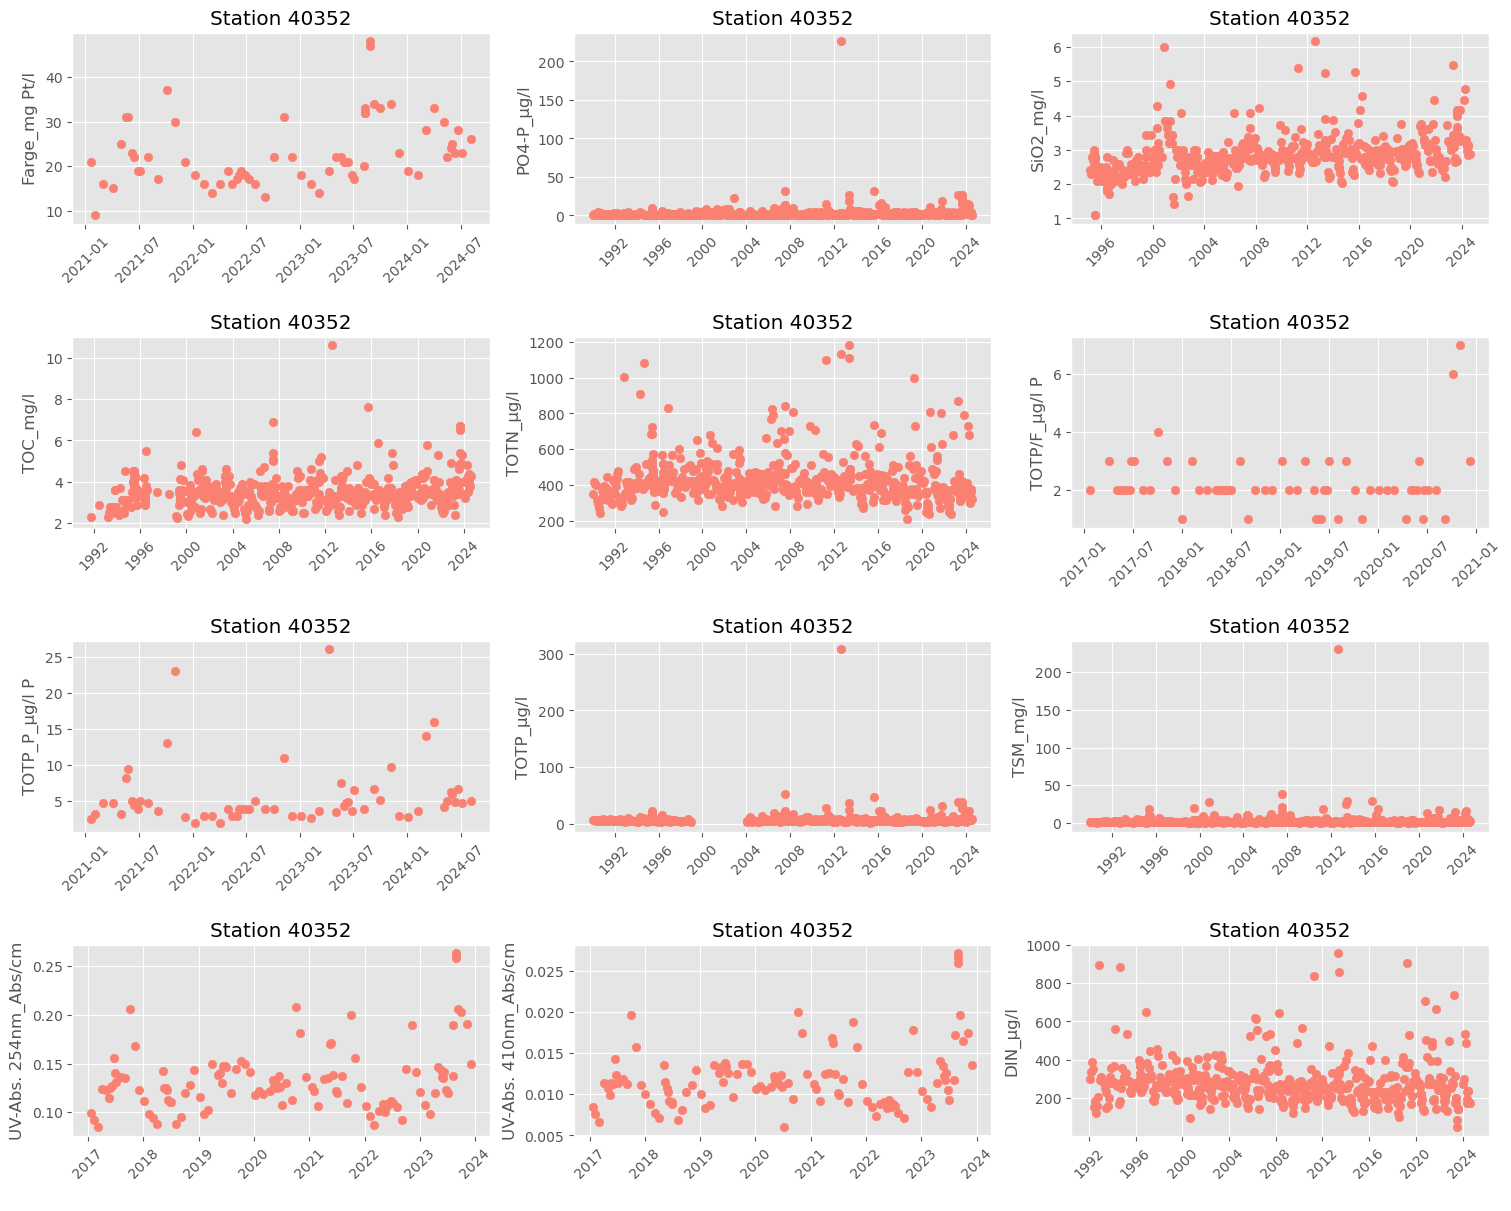

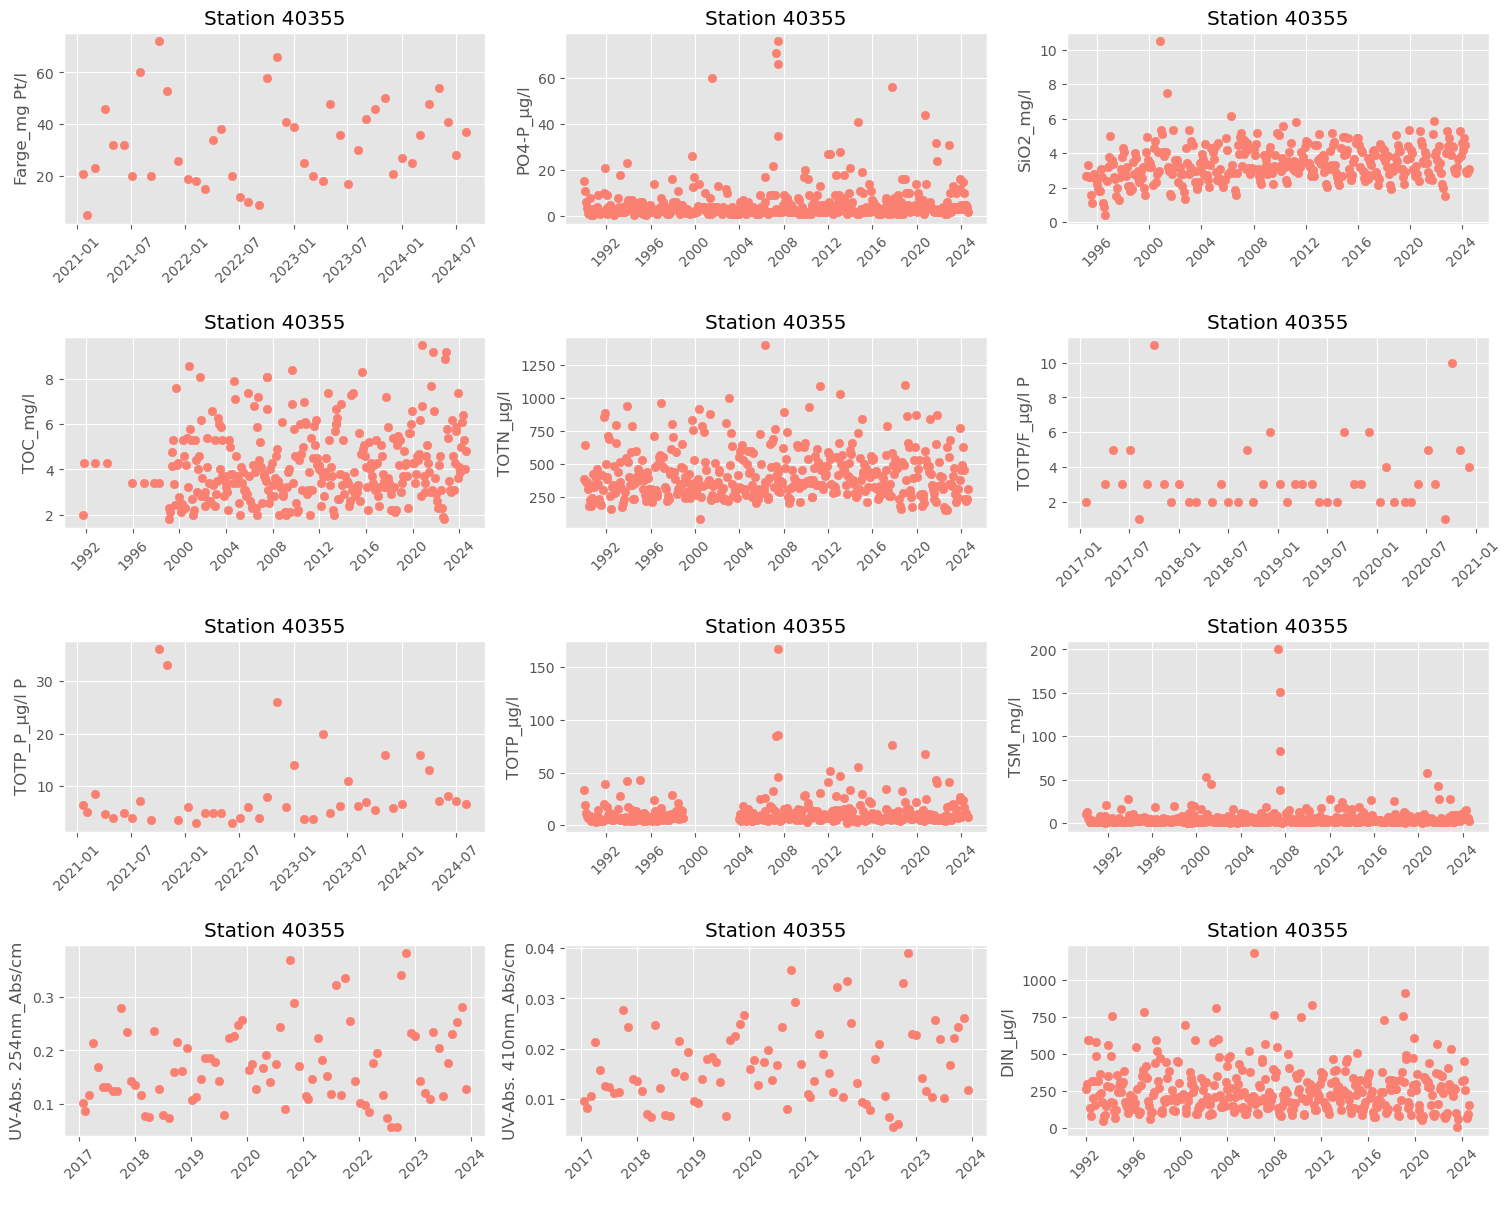

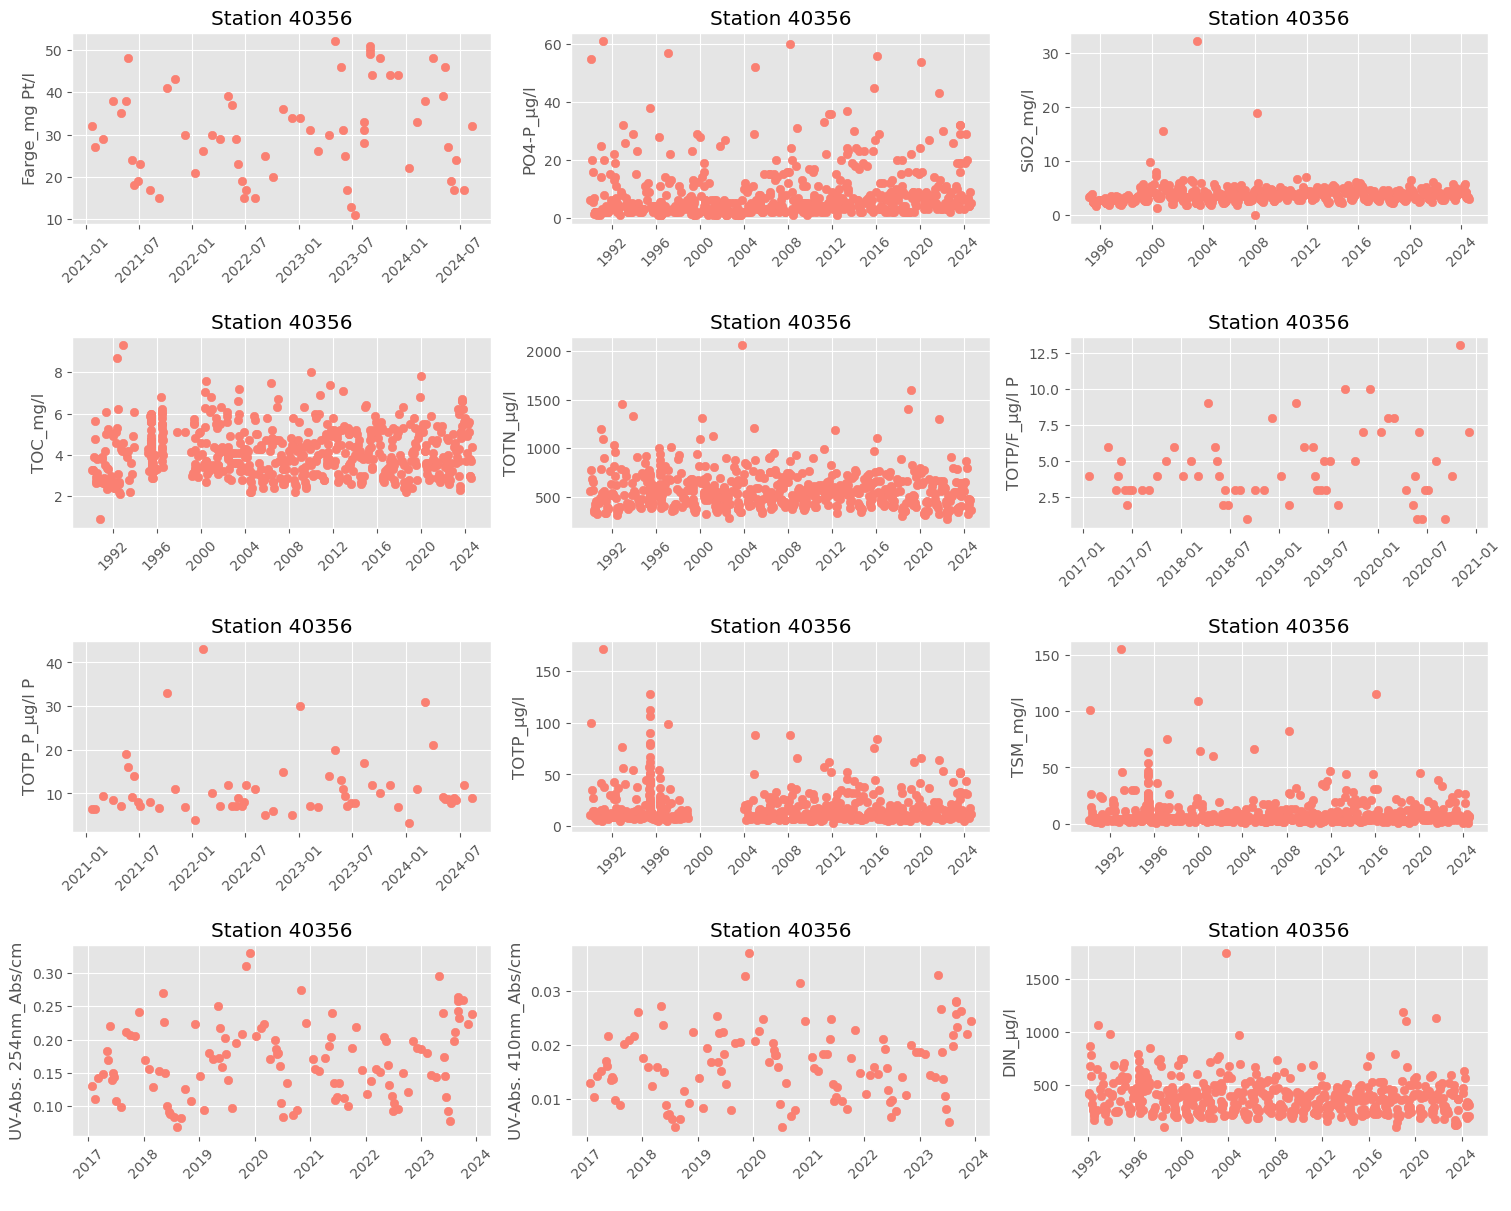

In [21]:
# Station Variable Scatter Plots
stations = wc_df["station_id"].unique()

num_cols = 3

for station in stations:
    station_df = wc_df[wc_df["station_id"] == station]
    
    variables = [col for col in station_df.columns 
                 if col not in ["station_id", "station_code", "station_name", "sample_date"] 
                 and "outlier" not in col]
    
    num_rows = (len(variables) + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)
    
    axes = axes.flatten()
    
    for i, var in enumerate(variables):
        ax = axes[i]
        ax.scatter(station_df["sample_date"], station_df[var], marker='o', color='salmon')
        ax.set_title(f"Station {station}")
        ax.set_xlabel(" ")
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=45)
       
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # plt.savefig("test_{}.png".format(station), format="png", dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
# Save as csv
wc_df.to_csv('../../data/river/water_chem/cleaned_niva/dremmen_glomma_numed_key_wc_species_flaged_2024.csv', index=False)

### 9. Remove outliers manualy 
After a quick visual inspection, we can clearly see some outliers. Some values have already been flagged using the MAD (Median Absolute Deviation) function; however, this method does not always work perfectly. I am replacing the outliers with NaN and saving the result in a separate file.

In [23]:
wc_df.loc[(wc_df['station_id'] == 40352) & (wc_df['PO4-P_µg/l'] > 200), ['PO4-P_µg/l']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40352) & (wc_df['TOC_mg/l'] > 10), ['TOC_mg/l']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40352) & (wc_df['TSM_mg/l'] > 200), ['TSM_mg/l']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40352) & (wc_df['TOTP_µg/l'] > 300), ['TOTP_µg/l']] = np.nan

wc_df.loc[(wc_df['station_id'] == 40355) & (wc_df['PO4-P_µg/l'] > 60), ['PO4-P_µg/l']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40355) & (wc_df['SiO2_mg/l'] > 6.5), ['SiO2_mg/l']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40355) & (wc_df['TOTN_µg/l'] > 1200), ['TOTN_µg/l']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40355) & (wc_df['TOTP_P_µg/l P'] > 30), ['TOTP_P_µg/l P']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40355) & (wc_df['TSM_mg/l'] > 50), ['TSM_mg/l']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40355) & (wc_df['TOTP_µg/l'] > 150), ['TOTP_µg/l']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40355) & (wc_df['sample_date'] < pd.Timestamp('1998-01-01')), 'TOC_mg/l'] = np.nan

wc_df.loc[(wc_df['station_id'] == 40356) & (wc_df['SiO2_mg/l'] > 10.5), ['SiO2_mg/l']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40356) & (wc_df['SiO2_mg/l'] < 0.1), ['SiO2_mg/l']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40356) & (wc_df['TOTN_µg/l'] > 2000), ['TOTN_µg/l']] = np.nan
wc_df.loc[(wc_df['station_id'] == 40356) & (wc_df['DIN_μg/l'] > 1500), ['DIN_μg/l']] = np.nan

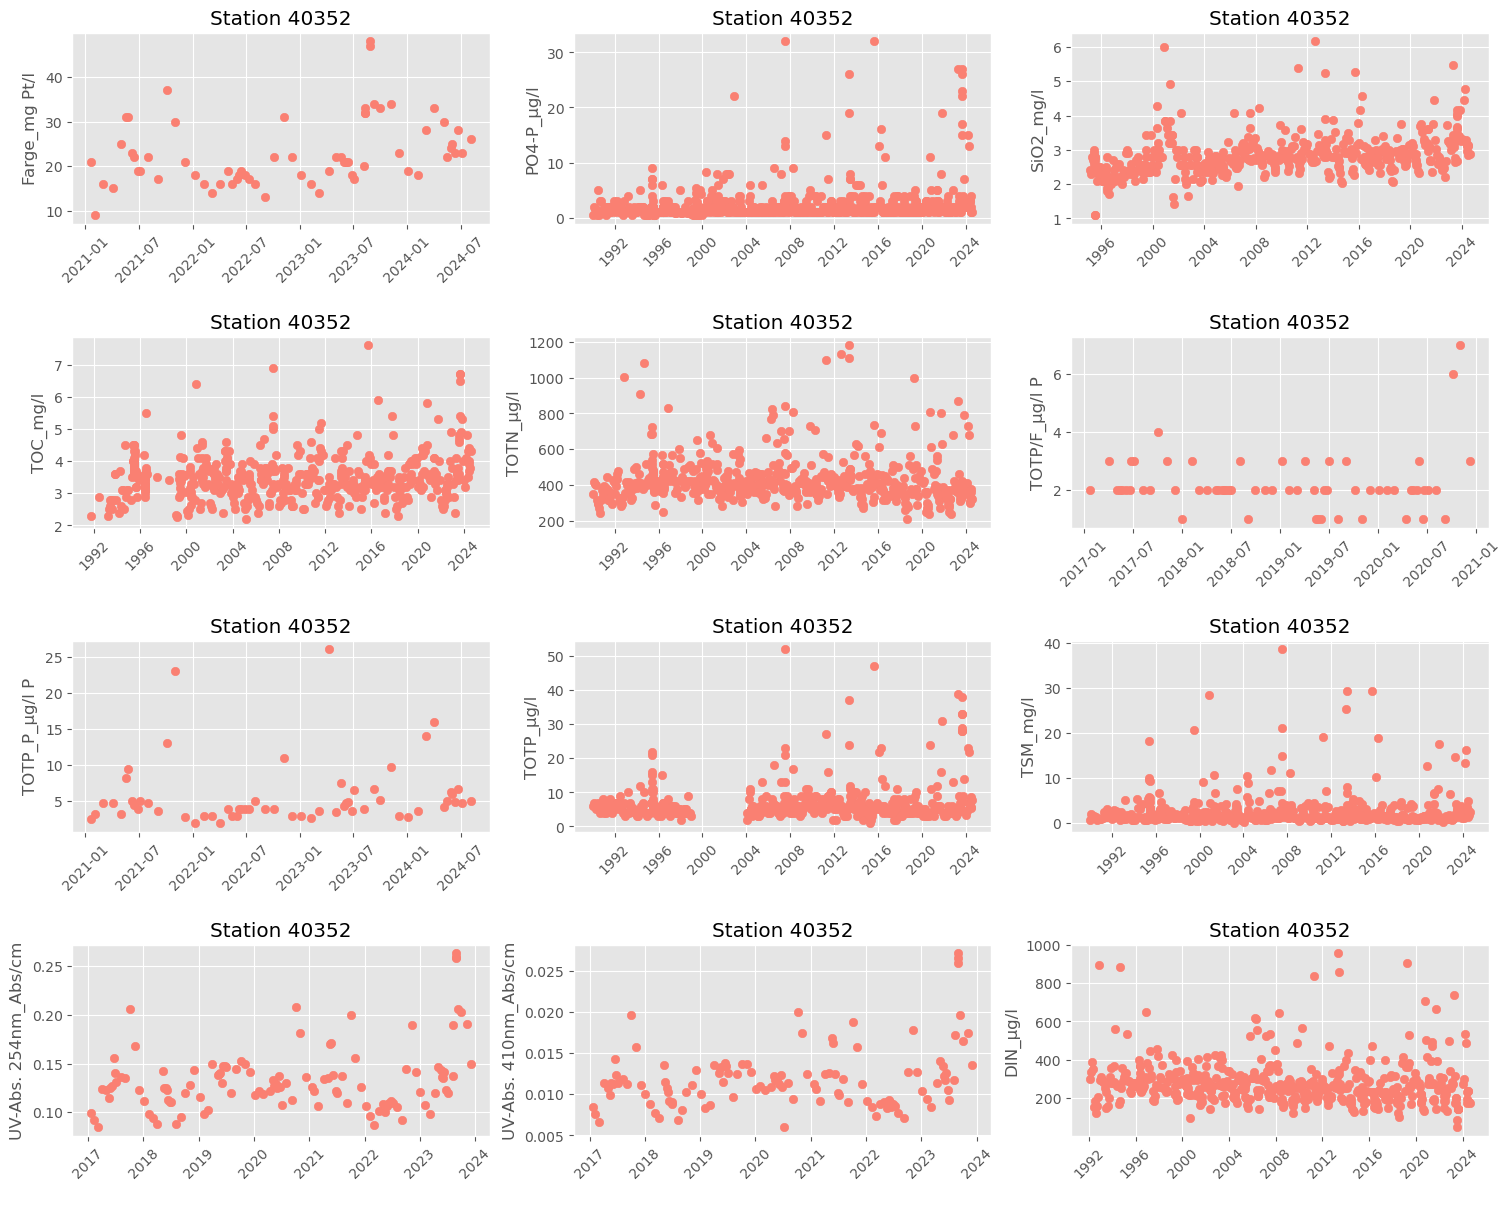

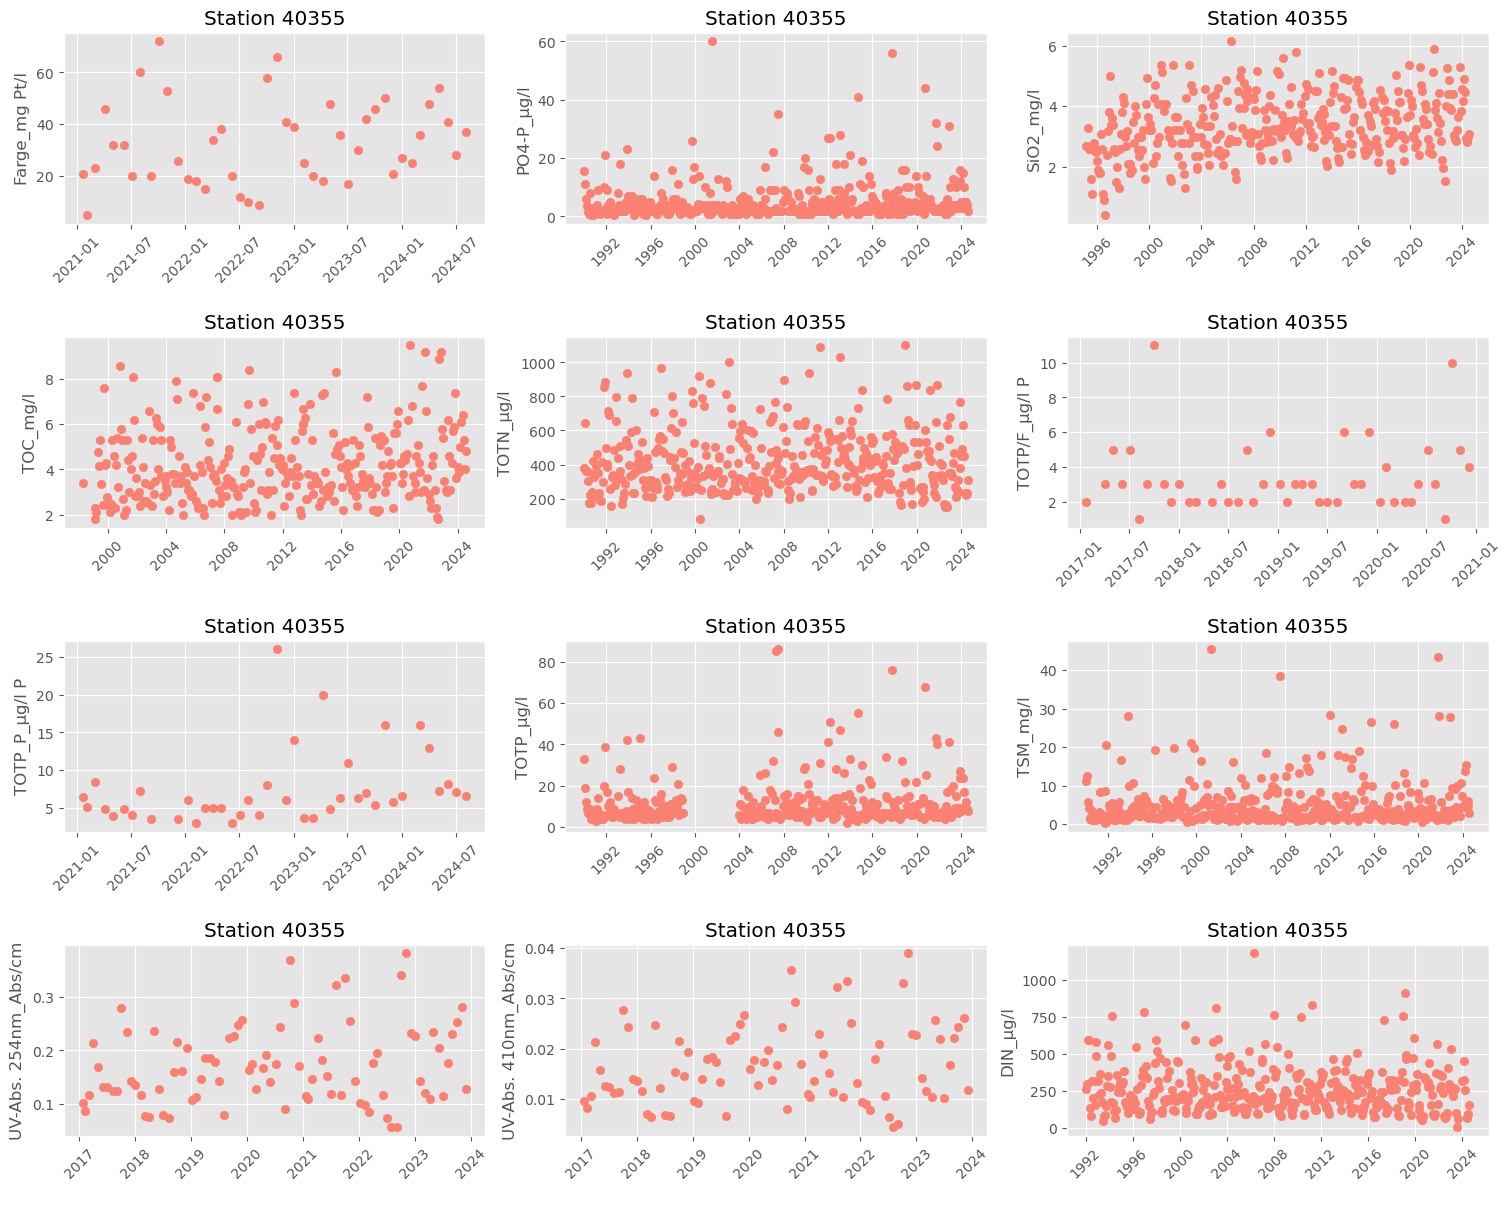

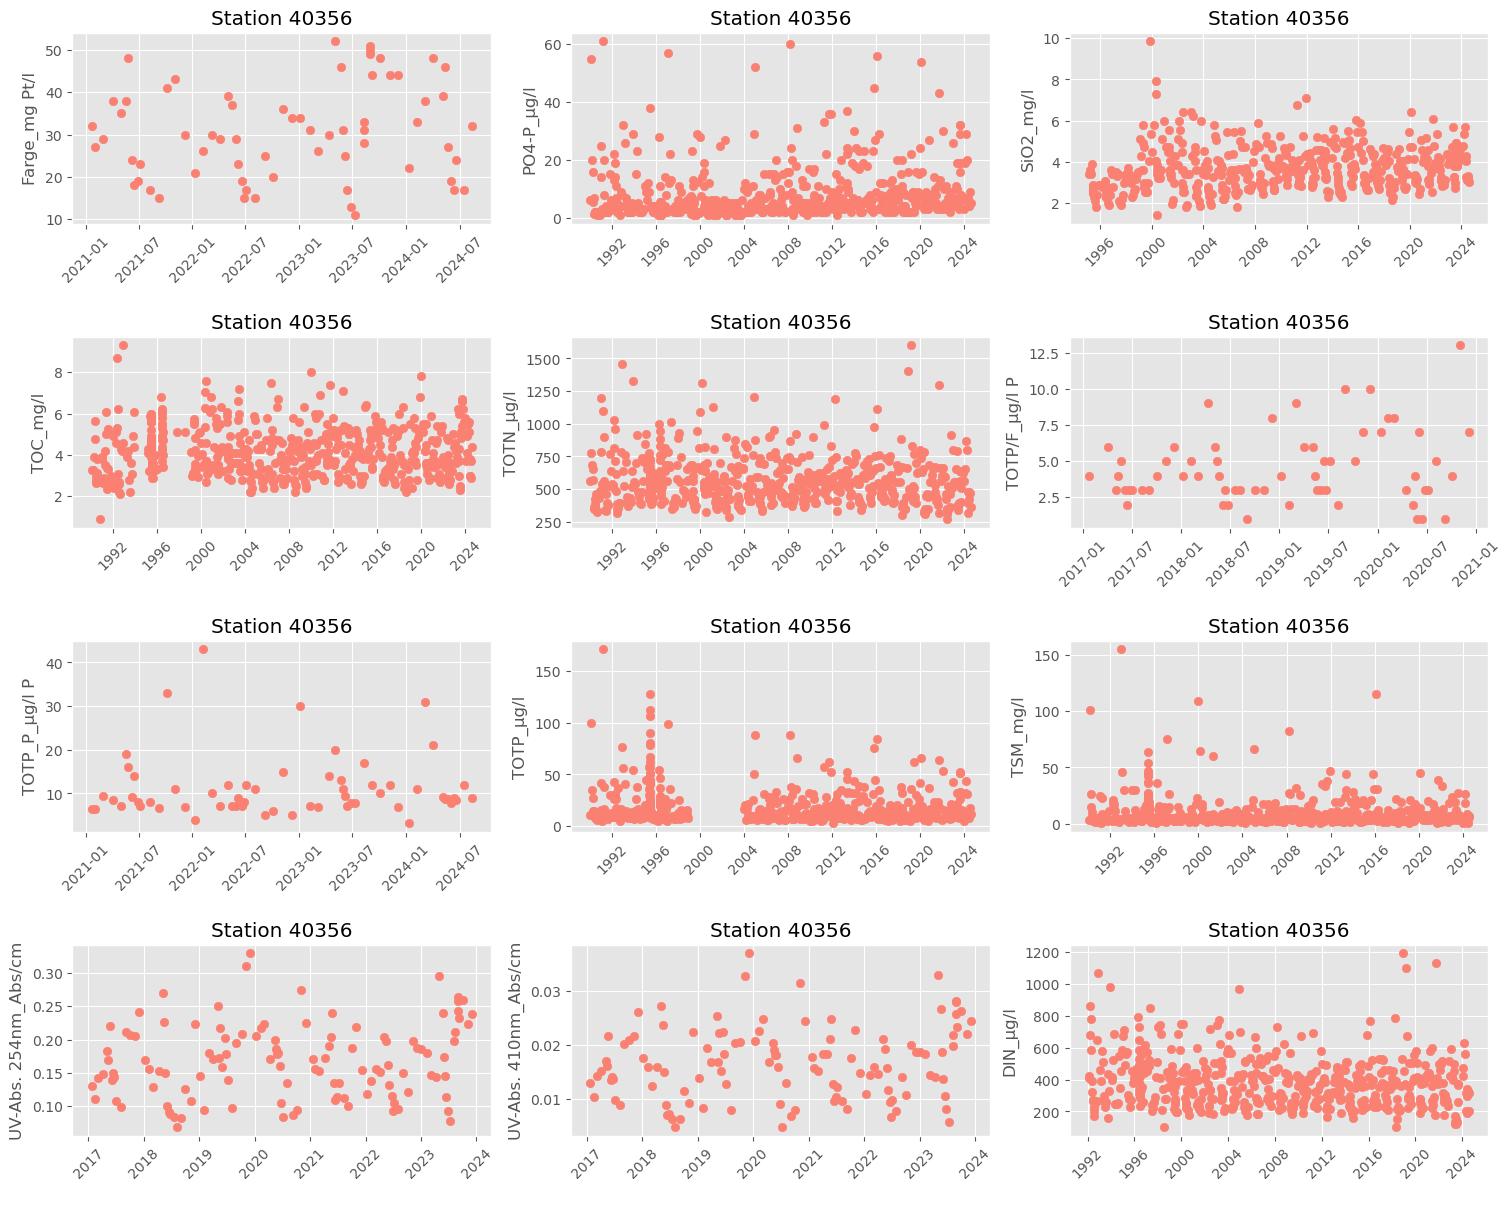

In [24]:
# Station Variable Scatter Plots
stations = wc_df["station_id"].unique()

num_cols = 3

for station in stations:
    station_df = wc_df[wc_df["station_id"] == station]
    
    variables = [col for col in station_df.columns 
                 if col not in ["station_id", "station_code", "station_name", "sample_date"] 
                 and "outlier" not in col]
    
    num_rows = (len(variables) + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)
    
    axes = axes.flatten()
    
    for i, var in enumerate(variables):
        ax = axes[i]
        ax.scatter(station_df["sample_date"], station_df[var], marker='o', color='salmon')
        ax.set_title(f"Station {station}")
        ax.set_xlabel(" ")
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=45)
       
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

In [25]:
wc_df.head()

station_id station_code                 station_name sample_date  \
0       40352         DRA1  Drammenselva v/Krokstadelva  1990-01-11   
1       40352         DRA1  Drammenselva v/Krokstadelva  1990-02-12   
2       40352         DRA1  Drammenselva v/Krokstadelva  1990-03-13   
3       40352         DRA1  Drammenselva v/Krokstadelva  1990-04-18   
4       40352         DRA1  Drammenselva v/Krokstadelva  1990-05-21   

   Farge_mg Pt/l outlier_Farge_mg Pt/l  PO4-P_µg/l outlier_PO4-P_µg/l  \
0            NaN                   NaN         0.5              False   
1            NaN                   NaN         2.0              False   
2            NaN                   NaN         1.5              False   
3            NaN                   NaN         1.5              False   
4            NaN                   NaN         0.5              False   

   SiO2_mg/l outlier_SiO2_mg/l  ...  TOTP_µg/l outlier_TOTP_µg/l  TSM_mg/l  \
0        NaN               NaN  ...        6.0             False       0.8   
1        NaN               NaN  ...        7.0             False       2.0   
2        NaN               NaN  ...        6.0             False       1.4   
3        NaN               NaN  ...        5.0             False       1.3   
4        NaN               NaN  ...        6.0             False       1.7   

  outlier_TSM_mg/l  UV-Abs. 254nm_Abs/cm outlier_UV-Abs. 254nm_Abs/cm  \
0            False                   NaN                          NaN   
1            False                   NaN                          NaN   
2            False                   NaN                          NaN   
3            False                   NaN                          NaN   
4            False                   NaN                          NaN   

   UV-Abs. 410nm_Abs/cm outlier_UV-Abs. 410nm_Abs/cm  DIN_μg/l  \
0                   NaN                          NaN       NaN   
1                   NaN                          NaN       NaN   
2                   NaN                          NaN       NaN   
3                   NaN                          NaN       NaN   
4                   NaN                          NaN       NaN   

  outlier_DIN_μg/l  
0            False  
1            False  
2            False  
3            False  
4            False  

[5 rows x 28 columns]

In [26]:
# Save as csv
wc_df.to_csv('../../data/river/water_chem/cleaned_niva/dremmen_glomma_numed_key_wc_species_cleaned_manualy_2024.csv', index=False)